# US Flights Data Exploration
## by Jesús Mira Aldao

## Preliminary Wrangling

This document explores the data related with the aeronautical sector in the USA along 25 years. The data have been gathered from the site [Statistical Computing](http://stat-computing.org/dataexpo/2009/the-data.html). In this page we can download information related with the flights made in the US territory since 1987 to 2008. This data englobes information like Distance, Time Schedules, Delays, etc. 

* I am going start making the necessary imports.

In [1]:
#basic data libraries
import pandas as pd
import numpy as np
#to interact with the local system
import os
import sys
import psutil

#imports to user timers and make conversions of time formats
from timeit import default_timer as timer
from datetime import datetime
import time

#import for stats
import statsmodels.api as sm
import random

#import to calculate if a point is inside a polygo.
#it is necessary to divide the airports in geographical regions
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

#imports to plot maps.
import plotly.express as px
import plotly.graph_objects as go

#matplotlib to display plots
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D 
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context("talk")

plt.style.use('seaborn-deep')
%matplotlib inline
random.seed(30)

* This is a short function to print the memory available in the computer.

In [2]:
def memory_report():
    print('Total memory: ',psutil.virtual_memory()[0])
    print('{}% of memory  used'.format(psutil.virtual_memory()[2]))

* First we load into a dataframe the file of the last year of data available.

<font color='red'>It is not necessary to execute the cells below again. They only prepare the datasets to work with.

In [3]:
====================================================================
REMOVE THIS TO EXECUTE THIS PART
====================================================================
#load one of the available files into a dataframe
start = timer()
df_2008 = pd.read_csv('data/2008.csv.bz2', index_col=None, header=0)
end = timer()
print('Seconds:', end-start)
memory_report()

SyntaxError: invalid syntax (<ipython-input-3-dbb8bb00160f>, line 1)

In [ ]:
====================================================================
REMOVE THIS TO EXECUTE THIS PART
====================================================================
# high-level overview of data shape and composition
print(df_2008.shape)
print(df_2008.info(null_counts = True))
print(df_2008.head(10))

After analyze this dataframe there are some changes that I would like to do  analayzing the columns of the original datasets.

* I prefer the columns `Year`, `Month`, `DayofMonth` and `DayOfWeek` as String type. I also would like to have one column with the `Date` putting together `Year`, `Month` and `DayofMonth`.

* I would also like to make somo analysis by route: `Origin Airport-Dest Airport`. In order to do these I going to create a new column String putting together these two fields.

* There are also a lot of null values. Specially in the delay columns, which had not been measured until 2003 and in columns as `DepTime`, `ArrTime` and `AirTime` in those rows corresponded to Cancelled fligts. In general I would like to fill these NaN values 0. 

After doing some vizualizations I have realized that It could be also useful to convert some variables to Ordinal Categorical variables. For example ordering the Carriers by number of flights, but I prefer to do these in the analysis part because the order can change depending on the visualization. I have only converted to categorical variagl `Month` and `DayOfWeek`.

In [ ]:
====================================================================
REMOVE THIS TO EXECUTE THIS PART
====================================================================
start = timer()
#Fill with 0 all the NaN values in the columns related with Time.
#Delays, air time, taxi in, taxi out, etc.
df_2008.CarrierDelay.fillna(0, inplace = True)
df_2008.WeatherDelay.fillna(0, inplace = True)
df_2008.NASDelay.fillna(0, inplace = True)
df_2008.SecurityDelay.fillna(0, inplace = True)
df_2008.LateAircraftDelay.fillna(0, inplace = True)
df_2008.CRSElapsedTime.fillna(0, inplace = True)
df_2008.ActualElapsedTime.fillna(0, inplace = True)
df_2008.ArrDelay.fillna(0, inplace = True)
df_2008.DepDelay.fillna(0, inplace = True)
df_2008.AirTime.fillna(0, inplace = True)
df_2008.TaxiIn.fillna(0, inplace = True)
df_2008.TaxiOut.fillna(0, inplace = True)
    
#Fill with "" all the NaN values in the columns related with Time.
#Delays, air time, actual arrival time, etc
df_2008.CRSDepTime.fillna('', inplace = True)
df_2008.CRSArrTime.fillna('', inplace = True)
df_2008.DepTime.fillna('', inplace = True)
df_2008.ArrTime.fillna('', inplace = True)
df_2008['CRSDepTime'] = df_2008['CRSDepTime'].astype(str).str.zfill(4)
df_2008['DepTime'] = df_2008['DepTime'].astype(str).str[:-2].str.zfill(4)
df_2008['ArrTime'] = df_2008['ArrTime'].astype(str).str[:-2].str.zfill(4)
df_2008['CRSArrTime'] = df_2008['CRSArrTime'].astype(str).str.zfill(4)
end = timer()
print('Seconds:', end-start)
memory_report()

* The first problem that I find here was that the datasets are too large to be managed by my PC as a whole. It is very difficult to work even with one single file, so I have decided to take a sample fo 500000 rows from the year 2008 to explore the relation between variables and saved it in a file to work more confortable. I am going to use this file to explore the relation between the different delays by flight. To  explore more longer periods of time I am going also to create three smaller files with the data grouped by Origin, Destination an Route (Origin-Dest) by day. With this four datasets I will be able to work without problems of memory.

In [ ]:
====================================================================
REMOVE THIS TO EXECUTE THIS PART
====================================================================
#takes a dataframe with 500000 samples.
start = timer()
samples = np.random.choice(df_2008.shape[0], 500000, replace = False)
df_2008_samp = df_2008.loc[samples,:]
end = timer()
print('Seconds:', end-start)
memory_report()

In [ ]:
====================================================================
REMOVE THIS TO EXECUTE THIS PART
====================================================================
#save this dataframe into a file
df_2008_samp.to_csv('data/2008_samp.csv.bz2',  index=False, mode = 'w', compression='bz2')

* In many cases we are not going to need the intra day information, so in order to be able to make explorations along several years I have decided to reduce the amount of data grouping by day and saving the results into a local data base file.

* According with the needs of the analysis I have created four new tables:

    * **CarrierByDay**: Data grouped by Carrier per day for all the years.
    * **OriginByDay**: Data grouped by origin Airport per day for all the years.
    * **DestByDay**: Data grouped by destination Airport per day for all the years. (Finally, I don't have used this file, so it is not included in the work).
    * **RouteByDay**: Data grouped by Route (Origin Airport-Dest Airport) per day. In this case I have selected only the year 2008 because the number of routes is too long and the resulting file for all the years will be too big.

In [ ]:
====================================================================
REMOVE THIS TO EXECUTE THIS PART. IT CAN TAKES OVER AN HOUR OR TWO TO FINISH
====================================================================

#gets a list wiht the file names that have to be loaded in the directory: data with extension: bz2.
folder_name = "data"
included_extensions = ['bz2']
file_names = [fn for fn in os.listdir(folder_name)
              if any(fn.endswith(ext) for ext in included_extensions)]

list_df = []
#connect with the file database using sqlite3
#conn = sqlite3.connect(folder_name + '/flights.db')
start = timer()

#The first time the mode of writting will be write and it writes the header.
write_mode= 'w'
write_header = True
#for each file in the previous list of file names
for file in file_names:
    print(file)
    #There is a problem with the field TailNum in the files 2001 and 2002.
    #The chars cannot be decoded as UTF-8. Anyway we don't need this data by the moment.
    try:
        df = pd.read_csv(folder_name + '/' + file, index_col=None, header=0)
    except UnicodeDecodeError:
        df = pd.read_csv(folder_name + '/' + file, index_col=None, header=0, encoding ='latin1')
    
    df['DayOfWeek'] = df['DayOfWeek'].astype(str)
    #It creates a new column with the date.
    df['Date'] = df['Year'].astype(str) + '-' + df['Month'].astype(str).str.zfill(2) + '-' + df['DayofMonth'].astype(str).str.zfill(2)
    
    #Fill with 0 all the NaN values in the columns related with Time.
    #Delays, air time, taxi in, taxi out, etc.
    df.CarrierDelay.fillna(0, inplace = True)
    df.WeatherDelay.fillna(0, inplace = True)
    df.NASDelay.fillna(0, inplace = True)
    df.SecurityDelay.fillna(0, inplace = True)
    df.LateAircraftDelay.fillna(0, inplace = True)
    df.CRSElapsedTime.fillna(0, inplace = True)
    df.ActualElapsedTime.fillna(0, inplace = True)
    df.ArrDelay.fillna(0, inplace = True)
    df.DepDelay.fillna(0, inplace = True)
    df.AirTime.fillna(0, inplace = True)
    df.TaxiIn.fillna(0, inplace = True)
    df.TaxiOut.fillna(0, inplace = True)
    
    #Fill with "" all the NaN values in the columns related with Time.
    #Delays, air time, actual arrival time, etc
    df.CRSDepTime.fillna('', inplace = True)
    df.CRSArrTime.fillna('', inplace = True)
    df.DepTime.fillna('', inplace = True)
    df.ArrTime.fillna('', inplace = True)
    df['CRSDepTime'] = df['CRSDepTime'].astype(str).str.zfill(4)
    df['DepTime'] = df['DepTime'].astype(str).str.zfill(4)
    df['ArrTime'] = df['ArrTime'].astype(str).str.zfill(4)
    df['CRSArrTime'] = df['CRSArrTime'].astype(str).str.zfill(4)
    
    #It creates the CarrierByDay table grouping by Date and UniqueCarrier. We also
    #add a column with the Count of rows grouped in each group.
    #It store the table in a file: CarrierByDay.csv.bz2.   
    df_aux1=pd.pivot_table(df, index=['Date', 'UniqueCarrier', 'DayOfWeek'],aggfunc=np.mean)
    df_aux2=pd.pivot_table(df, index=['Date', 'UniqueCarrier', 'DayOfWeek'], 
                           values='DayofMonth',
                           aggfunc=len).rename(columns = {'DayofMonth':'Count'})    
    df_aux1 = pd.concat([df_aux1,df_aux2],axis=1).reset_index()
    df_aux1.to_csv('data/CarrierByDay.csv.bz2',  index=False, mode = write_mode, compression='bz2', header = write_header)
    
    #It creates the OriginByDay table grouping by Date and Origin. We also
    #add a column with the Count of rows grouped in each group.
    #It store the table in a file: OriginByDay.csv.bz2. 
    df_aux1=pd.pivot_table(df, index=['Date', 'Origin', 'DayOfWeek'],aggfunc=np.mean)
    df_aux2=pd.pivot_table(df, index=['Date', 'Origin', 'DayOfWeek'], 
                           values='DayofMonth',
                           aggfunc=len).rename(columns = {'DayofMonth':'Count'})    
    df_aux1 = pd.concat([df_aux1,df_aux2],axis=1).reset_index()
    df_aux1.to_csv('data/OriginByDay.csv.bz2',  index=False, mode = write_mode, compression='bz2', header = write_header)
    
    #It creates the DestByDay table grouping by Date and Dest. We also
    #add a column with the Count of rows grouped in each group.
    #It store the table in a file: DestByDay.csv.bz2.
    df_aux1=pd.pivot_table(df, index=['Date', 'Dest', 'DayOfWeek'],aggfunc=np.mean)
    df_aux2=pd.pivot_table(df, index=['Date', 'Dest', 'DayOfWeek'], 
                           values='DayofMonth',
                           aggfunc=len).rename(columns = {'DayofMonth':'Count'})    
    df_aux1 = pd.concat([df_aux1,df_aux2],axis=1).reset_index()
    df_aux1.to_csv('data/DestByDay.csv.bz2',  index=False, mode = write_mode, compression='bz2', header = write_header)
    
    #The next part only applies in the last year: 2008.
    #It Defines a new column Route with the Origin and the Destiny.
    #It creates the CarrierByRoute table grouping by Date and Route. We also
    #add a column with the Count of rows grouped in each group.
    #It stores the table ina file: RouteByDay.csv.bz2.
    if file == '2008.csv.bz2':
        df['Route'] = df['Origin'] + '-' + df['Dest'] 
        df_aux1=pd.pivot_table(df, index=['Date', 'Route', 'DayOfWeek'],aggfunc=np.mean)
        df_aux2=pd.pivot_table(df, index=['Date', 'Route', 'DayOfWeek'], 
                               values='DayofMonth',
                               aggfunc=len).rename(columns = {'DayofMonth':'Count'})    
        df_aux1 = pd.concat([df_aux1,df_aux2],axis=1).reset_index()
        df_aux1.to_csv('data/RouteByDay.csv.bz2',  index=False, mode = 'w', compression='bz2', header = True)
    
    #the second and next times the mode of writing will be append and it does not write the header
    write_mode = 'a'
    write_header = False
    end = timer()
    print(end-start)
    memory_report()

<font color='red'>* You can continue executing the notebook here</font>

In [3]:
#Load the dataframe with the 500000 samples of 2008
start = timer()
folder_name = "data"
df_2008 = pd.read_csv(folder_name + '/2008_samp.csv.bz2', index_col=None, header=0)
end = timer()
print('Seconds:', end-start)
memory_report()

Seconds: 9.733665200000019
Total memory:  8465387520
62.5% of memory  used


In [4]:
#It changes the Type of the Date Time columns to String.
df_2008['Year'] = df_2008['Year'].astype(str)
df_2008['Month'] = df_2008['Month'].astype(str).str.zfill(2)
df_2008['DayofMonth'] = df_2008['DayofMonth'].astype(str).str.zfill(2)
df_2008['DayOfWeek'] = df_2008['DayOfWeek'].astype(str)
#It creates a new column with the date.
df_2008['Date'] = df_2008['Year'] + '-' + df_2008['Month'] + '-' + df_2008['DayofMonth']

#convert month to a ordered categorical variable
ordered_month = pd.api.types.CategoricalDtype(ordered = True, categories = ['01', '02', '03', '04', '05', '06',
                                                                            '07', '08', '09', '10', '11', '12'])
df_2008['Month'] = df_2008['Month'].astype(ordered_month)

#convert dayofweek to a ordered categorical variable
ordered_dow = pd.api.types.CategoricalDtype(ordered = True, categories = ['1', '2', '3', '4', '5', '6', '7'])
df_2008['DayOfWeek'] = df_2008['DayOfWeek'].astype(ordered_dow)

In [5]:
df_2008.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 30 columns):
Year                 500000 non-null object
Month                500000 non-null category
DayofMonth           500000 non-null object
DayOfWeek            500000 non-null category
DepTime              500000 non-null int64
CRSDepTime           500000 non-null int64
ArrTime              500000 non-null int64
CRSArrTime           500000 non-null int64
UniqueCarrier        500000 non-null object
FlightNum            500000 non-null int64
TailNum              494065 non-null object
ActualElapsedTime    500000 non-null float64
CRSElapsedTime       500000 non-null float64
AirTime              500000 non-null float64
ArrDelay             500000 non-null float64
DepDelay             500000 non-null float64
Origin               500000 non-null object
Dest                 500000 non-null object
Distance             500000 non-null int64
TaxiIn               500000 non-null float64
TaxiO

In [6]:
start = timer()
folder_name = "data"
df_carriers = pd.read_csv(folder_name + '/CarrierByDay.csv.bz2', index_col=None, header=0)
df_origins = pd.read_csv(folder_name + '/OriginByDay.csv.bz2', index_col=None, header=0)
df_routes = pd.read_csv(folder_name + '/RouteByDay.csv.bz2', index_col=None, header=0)
end = timer()
print('Seconds:', end-start)
memory_report()

Seconds: 62.557362499999954
Total memory:  8465387520
50.1% of memory  used


In [7]:
df_carriers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102234 entries, 0 to 102233
Data columns (total 23 columns):
Date                 102234 non-null object
UniqueCarrier        102234 non-null object
DayOfWeek            102234 non-null int64
ActualElapsedTime    102234 non-null float64
AirTime              102234 non-null float64
ArrDelay             102234 non-null float64
CRSElapsedTime       102234 non-null float64
Cancelled            102234 non-null float64
CarrierDelay         102234 non-null float64
DayofMonth           102234 non-null int64
DepDelay             102234 non-null float64
Distance             102234 non-null float64
Diverted             102234 non-null float64
FlightNum            102234 non-null float64
LateAircraftDelay    102234 non-null float64
Month                102234 non-null int64
NASDelay             102234 non-null float64
SecurityDelay        102234 non-null float64
TaxiIn               102234 non-null float64
TaxiOut              102234 non-null float

In [8]:
df_carriers.head()

Date UniqueCarrier  DayOfWeek  ActualElapsedTime  AirTime   ArrDelay  \
0  1987-10-01            AA          4         117.228697      0.0   5.597581   
1  1987-10-01            AS          4          85.497976      0.0  11.850202   
2  1987-10-01            CO          4         119.881579      0.0   0.624654   
3  1987-10-01            DL          4          99.025904      0.0   8.043500   
4  1987-10-01            EA          4         101.327645      0.0   6.210751   

   CRSElapsedTime  Cancelled  CarrierDelay  DayofMonth  ...   FlightNum  \
0      119.084662   0.009896           0.0           1  ...  789.942276   
1       84.607287   0.040486           0.0           1  ...  228.821862   
2      122.867729   0.001385           0.0           1  ...  825.819945   
3       95.556207   0.004888           0.0           1  ...  833.302542   
4      101.769625   0.010239           0.0           1  ...  595.347270   

   LateAircraftDelay  Month  NASDelay  SecurityDelay  TaxiIn  TaxiOut  \
0                0.0     10       0.0            0.0     0.0      0.0   
1                0.0     10       0.0            0.0     0.0      0.0   
2                0.0     10       0.0            0.0     0.0      0.0   
3                0.0     10       0.0            0.0     0.0      0.0   
4                0.0     10       0.0            0.0     0.0      0.0   

   WeatherDelay  Year  Count  
0           0.0  1987   1819  
1           0.0  1987    247  
2           0.0  1987   1444  
3           0.0  1987   2046  
4           0.0  1987   1172  

[5 rows x 23 columns]

In [9]:
df_routes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1538856 entries, 0 to 1538855
Data columns (total 23 columns):
Date                 1538856 non-null object
Route                1538856 non-null object
DayOfWeek            1538856 non-null int64
ActualElapsedTime    1538856 non-null float64
AirTime              1538856 non-null float64
ArrDelay             1538856 non-null float64
CRSElapsedTime       1538856 non-null float64
Cancelled            1538856 non-null float64
CarrierDelay         1538856 non-null float64
DayofMonth           1538856 non-null int64
DepDelay             1538856 non-null float64
Distance             1538856 non-null int64
Diverted             1538856 non-null float64
FlightNum            1538856 non-null float64
LateAircraftDelay    1538856 non-null float64
Month                1538856 non-null int64
NASDelay             1538856 non-null float64
SecurityDelay        1538856 non-null float64
TaxiIn               1538856 non-null float64
TaxiOut              15

In [10]:
df_routes.head()

Date    Route  DayOfWeek  ActualElapsedTime     AirTime    ArrDelay  \
0  2008-01-01  ABE-ATL          2              157.0  136.500000   22.000000   
1  2008-01-01  ABE-CLE          2               79.0   61.000000   30.000000   
2  2008-01-01  ABE-CLT          2              117.0  102.000000   10.000000   
3  2008-01-01  ABE-DTW          2              117.0   89.333333   39.666667   
4  2008-01-01  ABE-ORD          2              138.0  109.333333  107.000000   

   CRSElapsedTime  Cancelled  CarrierDelay  DayofMonth  ...  FlightNum  \
0      139.000000        0.0      7.000000           1  ...     5145.0   
1       77.000000        0.0      0.000000           1  ...     2586.0   
2      102.000000        0.0      0.000000           1  ...     1821.0   
3      111.666667        0.0      0.000000           1  ...     2938.0   
4      135.333333        0.0     14.333333           1  ...     6758.0   

   LateAircraftDelay  Month   NASDelay  SecurityDelay  TaxiIn    TaxiOut  \
0           0.000000      1   9.000000            0.0    10.0  10.500000   
1          28.000000      1   2.000000            0.0     9.0   9.000000   
2           0.000000      1   0.000000            0.0     4.0  11.000000   
3          34.666667      1   1.333333            0.0    13.0  14.666667   
4          42.000000      1  50.666667            0.0    21.0   7.666667   

   WeatherDelay  Year  Count  
0           0.0  2008      2  
1           0.0  2008      2  
2           0.0  2008      1  
3           0.0  2008      3  
4           0.0  2008      3  

[5 rows x 23 columns]

* I am also going to use two additional datasets with information about the airports and the carriers. In this datasets we can find the complete name of the airports and carriers and the geographical position of the airports. 

In [11]:
df_airports_inf = pd.read_csv('data/airports.csv', index_col=None, header=0)
df_carriers_inf = pd.read_csv('data/carriers.csv', index_col=None, header=0)

In [12]:
df_airports_inf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 7 columns):
iata       3376 non-null object
airport    3376 non-null object
city       3364 non-null object
state      3364 non-null object
country    3376 non-null object
lat        3376 non-null float64
long       3376 non-null float64
dtypes: float64(2), object(5)
memory usage: 184.8+ KB


In [13]:
df_airports_inf.head()

iata               airport              city state country        lat  \
0  00M              Thigpen        Bay Springs    MS     USA  31.953765   
1  00R  Livingston Municipal        Livingston    TX     USA  30.685861   
2  00V           Meadow Lake  Colorado Springs    CO     USA  38.945749   
3  01G          Perry-Warsaw             Perry    NY     USA  42.741347   
4  01J      Hilliard Airpark          Hilliard    FL     USA  30.688012   

         long  
0  -89.234505  
1  -95.017928  
2 -104.569893  
3  -78.052081  
4  -81.905944

In [14]:
df_carriers_inf.head()

Code                    Description
0  02Q                  Titan Airways
1  04Q             Tradewind Aviation
2  05Q            Comlux Aviation, AG
3  06Q  Master Top Linhas Aereas Ltd.
4  07Q            Flair Airlines Ltd.

In [15]:
df_carriers_inf.head()

Code                    Description
0  02Q                  Titan Airways
1  04Q             Tradewind Aviation
2  05Q            Comlux Aviation, AG
3  06Q  Master Top Linhas Aereas Ltd.
4  07Q            Flair Airlines Ltd.

### What is the structure of your dataset?


* The data available contains in total 25 compressed csv files, one file by year. All of them have the same structre. Each row in each dataset holds the information related to a single flight. This informations is composed by the following columns:

Variable descriptions

* **Year:**	1987-2008
* **Month:**	1-12
* **DayofMonth:**	1-31
* **DayOfWeek:**	1 (Monday) - 7 (Sunday)
* **DepTime:**	actual departure time (local, hhmm)
* **CRSDepTime:**	scheduled departure time (local, hhmm)
* **ArrTime:**	actual arrival time (local, hhmm)
* **CRSArrTime:**	scheduled arrival time (local, hhmm)
* **UniqueCarrier:**	unique carrier code
* **FlightNum:**	flight number
* **TailNum:**	plane tail number
* **ActualElapsedTime:**	in minutes
* **CRSElapsedTime:**	in minutes
* **AirTime	in minutes:**
* **ArrDelay:**	arrival delay, in minutes
* **DepDelay:**	departure delay, in minutes
* **Origin:**	origin IATA airport code
* **Dest:**	destination IATA airport code
* **Distance:**	in miles
* **TaxiIn:**	taxi in time, in minutes
* **TaxiOut:**	taxi out time in minutes
* **Cancelled:**	was the flight cancelled?
* **CancellationCode:**	reason for cancellation (A = carrier, B = weather, C = NAS, D = security)
* **Diverted:**	1 = yes, 0 = no
* **CarrierDelay:**	in minutes
* **WeatherDelay:**	in minutes
* **NASDelay:**	in minutes
* **SecurityDelay:**	in minutes
* **LateAircraftDelay:**	in minutes

Most of the variables are numerical, even those related with dates and times which are Integer or Float. We have changed these ones to String.

There are also some categorical variables as `UniqueCarrier`, `Origin`, `Dest`, `CancellationCode` and `TailNum`.

And the columns `Cancelled` and `Diverted` are boolean.

The datasets that I am going to work with are files with information of flights grouped bye day and Route, Destination or Origin. Using the mean to do compute the result value.
I am also going to use a dataset with information about flights for the year 2008.



### What is/are the main feature(s) of interest in your dataset?

I find interesting to analyze the behaviour of the different delay causes in relation with other variables like the geographical area, the day of week, day of month, etc. I am not sure of which of this relationships could be more interesting, we are going to see that allong the analysis.

I am interested also in knowing if there are routes that can be changed by other means of transport like modern hight speed trains, hyperloop, or something similar. I have the idea of searching for busy routes with a mean speed slower enough so that a train could compete with the flights.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

I expect Wheather Delay depends on the Airport (or geographical area) and the season (or Month) of the year. The other causes of delay it can be more difficult to anticipate a relationship.

For the exploring of the routes that could be changed by a train it can be useful to search for those who have a great number of flights per day and the mean speed of the trip is relatively slow. To calculate this speed we need to know the distance and the total time spended on them. This time should be the elapsed time on the flights more the delays acumulated.


### Analysis of relations between the different variables of time.

* Before starting the analysis of the different variables in the dataset, I would like to clear myself about the relation between the different variables of time and delays: `ArrDelay`, `Departure Delay`, `CRSElapsedTime`, `ActualElapsedTime`, `TaxiIn`, `TaxiOut`, `AirTime`, `CarrierDelay`, `WeatherDelay`, `NASDelay`, `SecurityDelay` and `LateAircraftDelay`. They can be a bit confussing, at least for me. It seems pretty obvious than ones are include in others ant to calculate the total delay we can not simply sum all the variables that contains a delay.

As I said, I am interested in knowing the average speed of the different routes, and to know this I need an estimation of the total time that is needed to do this journey. The times of departure and arrival are in local time, so you cannot simply make the difference. The other way of knowing this is to sum the elapsed time and the delays, but I need to know which delays I have to use, because I suppose that some times are included in others.

To know that I have searched for linear relationships between the time variables. I have achieved some conclusions. I would like to make it clear that I am concious that correlation does not mean causation, but in this case, taking into account the meaning of the variables (delays or elapsed times) and the linearity between them, it seems pretty clear that correlation means causation and that some times are included in others.

In [16]:
#Linear relation between 'ActualElapsedTime' and 'CRSElapsedTime', 'ArrDelay', 'DepDelay'
start = timer()
df_2008_not_cancelled = df_2008.query('Cancelled == False').sample(50000)
df_2008_not_cancelled['intercept'] = 1

lm = sm.OLS(df_2008_not_cancelled['ActualElapsedTime'], df_2008_not_cancelled[['intercept', 'CRSElapsedTime', 'ArrDelay', 'DepDelay']])
results = lm.fit()
end = timer()
print('Seconds:', end-start)
results.summary()


Seconds: 1.0096431000000052


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      ActualElapsedTime   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 1.101e+06
Date:                Wed, 04 Dec 2019   Prob (F-statistic):               0.00
Time:                        10:46:51   Log-Likelihood:            -1.7807e+05
No. Observations:               50000   AIC:                         3.561e+05
Df Residuals:                   49996   BIC:                         3.562e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          0.4276      0.081      5.283      0.000       0.269       0.586
CRSElapsedTime     0.9938      0.001   1796.952      0.000       0.993       0.995
ArrDelay           1.0028      0.003    371.516      0.000       0.998       1.008
DepDelay          -1.0010      0.003   -341.120      0.000      -1.007      -0.995
==============================================================================
Omnibus:                   124501.619   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       2026089200.093
Skew:                         -27.235   Prob(JB):                         0.00
Kurtosis:                     987.660   Cond. No.                         311.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**From this relationship we can conclude that:**

**ActualElapsedTime + DepDelay = CRSElapsedTime + ArrDelay**




In [17]:
#Linear relation between 'ActualElapsedTime' and 'AirTime', 'AirTime', 'TaxiOut', 'TaxiIn'
start = timer()
lm = sm.OLS(df_2008_not_cancelled['ActualElapsedTime'], df_2008_not_cancelled[['intercept', 'AirTime', 'TaxiOut', 'TaxiIn']])
results = lm.fit()
end = timer()
print('Seconds:', end-start)
results.summary()

Seconds: 0.10013880000002473


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      ActualElapsedTime   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.393e+07
Date:                Wed, 04 Dec 2019   Prob (F-statistic):               0.00
Time:                        10:46:51   Log-Likelihood:                -81152.
No. Observations:               50000   AIC:                         1.623e+05
Df Residuals:                   49996   BIC:                         1.623e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1439      0.014    -10.279      0.000      -0.171      -0.116
AirTime        1.0012   8.27e-05   1.21e+04      0.000       1.001       1.001
TaxiOut        0.9944      0.001   1987.669      0.000       0.993       0.995
TaxiIn         1.0086      0.001    931.075      0.000       1.006       1.011
==============================================================================
Omnibus:                   134409.810   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       3872051538.180
Skew:                         -33.042   Prob(JB):                         0.00
Kurtosis:                    1364.697   Cond. No.                         317.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**From this relationship we can conclude that:**

**ActualElapsedTime = AirTime + TaxiIn + TaxiOut**

In [18]:
#Linear relation between 'ArrDelay' and 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'
start = timer()
lm = sm.OLS(df_2008_not_cancelled['ArrDelay'], df_2008_not_cancelled[['intercept', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']])
results = lm.fit()
end = timer()
print('Seconds:', end-start)
results.summary()

Seconds: 0.09962330000001884


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ArrDelay   R-squared:                       0.948
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                 1.814e+05
Date:                Wed, 04 Dec 2019   Prob (F-statistic):               0.00
Time:                        10:46:52   Log-Likelihood:            -1.8084e+05
No. Observations:               50000   AIC:                         3.617e+05
Df Residuals:                   49994   BIC:                         3.617e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept            -5.0381      0.043   -117.831      0.000      -5.122      -4.954
CarrierDelay          1.0335      0.002    540.083      0.000       1.030       1.037
WeatherDelay          1.0303      0.005    215.773      0.000       1.021       1.040
NASDelay              1.0588      0.002    432.627      0.000       1.054       1.064
SecurityDelay         1.1671      0.061     19.207      0.000       1.048       1.286
LateAircraftDelay     1.0421      0.002    548.352      0.000       1.038       1.046
==============================================================================
Omnibus:                     3963.381   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6273.268
Skew:                          -0.615   Prob(JB):                         0.00
Kurtosis:                       4.223   Cond. No.                         34.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**From this relationship we can conclude that:**

**ArrDelay = CarrierDelay + WeatherDelay + NASDelay + SecurityDelay + LateAircraftDelay**

It seems that there is another cause of delay that we are not taking into account, but the aproximation that I have put above seems very accurate. 

**I have depicted this relationships in the next graph:**

![alt text](data/Graphic_Times.jpg)

Again, I know that correlation does not mean causation, but according to the nature of these variables: all of them are delays, and all the coefficients and R-Squared are closed to 1, I think that this is one of the cases in wich correlation means causation.

According to this the total time spent in a route can be estimated as:


**Total Time = Escheduled Elapsed Time + CarrierDelay + Wheather Delay + NAS Delay + Security Delay + Late Aircraft Delay**


This conclusion could be explained in the description of the parameters, but I didn't see it in the documentation of the original datasets.


## Univariate Exploration


* I will start by drawing the distribution of the air time in linear scale and logaritmic scale.

In [19]:
df_2008['AirTime'].max(), df_2008['AirTime'].min()

(658.0, 0.0)

Seconds: 0.30136609999999564
Total memory:  8465387520
50.3% of memory  used


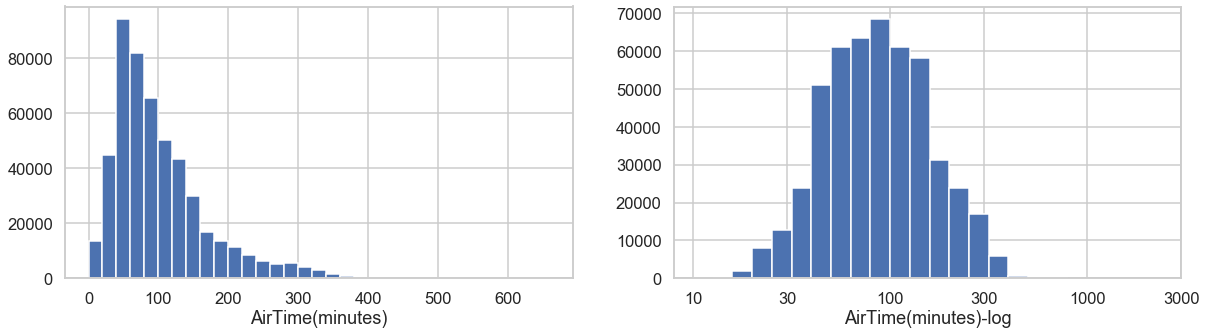

In [20]:
start = timer()
plt.figure(figsize = [20, 5])
#It plots the distribution of the air time
plt.subplot(1, 2, 1)
bin_edges = np.arange(0, df_2008['AirTime'].max()+20, 20)
sns.distplot(df_2008['AirTime'], bins = bin_edges, kde = False,
            hist_kws = {'alpha' : 1});
plt.xlabel('AirTime(minutes)')

#It plots the log distribution of the air time
plt.subplot(1, 2, 2)
bin_edges = 10 ** np.arange(1, np.log10(df_2008['AirTime'].max())+0.1, 0.1)
plt.hist(df_2008['AirTime'], bins = bin_edges)
plt.xscale('log')
plt.xlabel('AirTime(minutes)-log')
tick_locs = [10, 30, 100, 300, 1000, 3000]
plt.xticks(tick_locs, tick_locs);

end = timer()
print('Seconds:', end-start)
memory_report()

We can see that in linear scale the distribution is clearly right skewed and long-tailed, while in logaritmic scale es is pretty similar to a log-normal distribution. Most of the distances are below 300 miles.

* Another variables that will be relevant are the `ActualElapsedTime` and the `CRSlElapsedTime`.

In [21]:
print(df_2008['ActualElapsedTime'].max(), df_2008['ActualElapsedTime'].min())
print(df_2008['CRSElapsedTime'].max(), df_2008['CRSElapsedTime'].min())

683.0 0.0
1435.0 -9.0


An Scheduled Elapsed Time negative. It is strange, but I am not going to delete any row by now. Anyway due to the large amount of data it is not statistically significant.

Seconds: 0.6921310000000176
Total memory:  8465387520
50.4% of memory  used


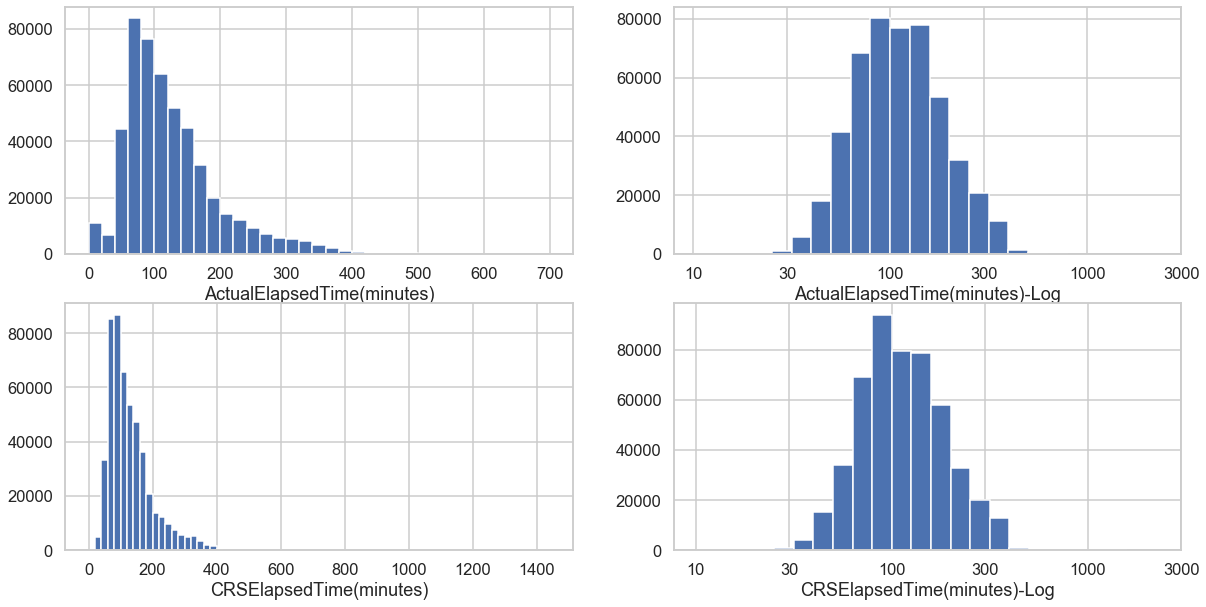

In [22]:
start = timer()

fig, ax = plt.subplots(nrows=2, figsize = [20, 10])
#It plots the distribution of the actual elapsed time
plt.subplot(2, 2, 1)
bin_edges = np.arange(0, df_2008['ActualElapsedTime'].max()+20, 20)
sns.distplot(df_2008['ActualElapsedTime'], bins = bin_edges, kde = False, hist_kws = {'alpha' : 1});
plt.xlabel('ActualElapsedTime(minutes)')

#It plots the log distribution of the actual elapsed time
plt.subplot(2, 2, 2)
bin_edges = 10 ** np.arange(1, np.log10(df_2008['ActualElapsedTime'].max())+0.1, 0.1)
plt.hist(df_2008['ActualElapsedTime'], bins = bin_edges)
plt.xscale('log')
tick_locs = [10, 30, 100, 300, 1000, 3000]
plt.xticks(tick_locs, tick_locs);
plt.xlabel('ActualElapsedTime(minutes)-Log')

#It plots the distribution of the CRS elapsed time
plt.subplot(2, 2, 3)
bin_edges = np.arange(0, df_2008['CRSElapsedTime'].max()+20, 20)
sns.distplot(df_2008['CRSElapsedTime'], bins = bin_edges, kde = False, hist_kws = {'alpha' : 1});
plt.xlabel('CRSElapsedTime(minutes)')

#It plots the log distribution of the CRS elapsed time
plt.subplot(2, 2, 4)
bin_edges = 10 ** np.arange(1, np.log10(df_2008['CRSElapsedTime'].max())+0.1, 0.1)
plt.hist(df_2008['CRSElapsedTime'], bins = bin_edges)
plt.xscale('log')
tick_locs = [10, 30, 100, 300, 1000, 3000]
plt.xticks(tick_locs, tick_locs);
plt.xlabel('CRSElapsedTime(minutes)-Log')

end = timer()
print('Seconds:', end-start)
memory_report()

In these cases the distribution is also right skewed in the linear scale and fairly normal in the logaritmic scale, specially in the case of the Actual Elapsed Time.

* I will continue depicting the distribution of the different delays.

I start with the distributions of the `Departure Delay` and `Arrival Delay`. The first thing that I consider strange is that there are negative values, but probably they are not errors. It can be normal to departure earlier than the scheduled time.

In [23]:
df_2008['DepDelay'].max(), df_2008['DepDelay'].min()

(1952.0, -62.0)

In [24]:
df_2008['ArrDelay'].max(), df_2008['ArrDelay'].min()

(1951.0, -81.0)

In [25]:
df_2008.query('ArrDelay < -60 | DepDelay < -60 ').shape

(25, 30)

In [26]:
df_2008.query('ArrDelay < -60 | DepDelay < -60 ')[['Date',
                                                    'UniqueCarrier', 
                                                    'Origin', 
                                                    'Dest', 
                                                    'ArrDelay', 
                                                    'DepDelay', 
                                                    'CRSArrTime', 
                                                    'ArrTime', 
                                                    'CRSDepTime', 
                                                    'DepTime']].sort_values(['DepDelay', 'ArrDelay']).head(10)

Date UniqueCarrier Origin Dest  ArrDelay  DepDelay  CRSArrTime  \
279201  2008-01-27            YV    PHX  SBA      -4.0     -62.0         849   
58404   2008-01-09            AQ    SNA  KOA     -75.0     -13.0        1310   
482320  2008-11-04            AA    LGA  DFW     -66.0     -12.0        1630   
69125   2008-11-18            UA    LGA  DEN     -64.0     -12.0        1335   
64575   2008-03-26            OH    JFK  AUS     -81.0     -10.0        2341   
340119  2008-08-26            UA    JFK  LAX     -64.0     -10.0        2223   
327691  2008-04-19            US    LAS  TPA     -63.0      -9.0        2342   
104075  2008-11-29            B6    JFK  LAS     -62.0      -9.0        2158   
496712  2008-04-19            AS    EWR  SEA     -65.0      -8.0        1107   
429629  2008-11-06            AA    BOS  DFW     -63.0      -8.0         940   

        ArrTime  CRSDepTime  DepTime  
279201      845         812      710  
58404      1155         900      847  
482320     1524        1310     1258  
69125      1231        1059     1047  
64575      2220        1930     1920  
340119     2119        1859     1849  
327691     2239        1610     1601  
104075     2056        1840     1831  
496712     1002         740      732  
429629      837         600      552

Anyway the negative part of the distribution is highly left skewed and almost all the values are less than an hour, although some of the are very large.

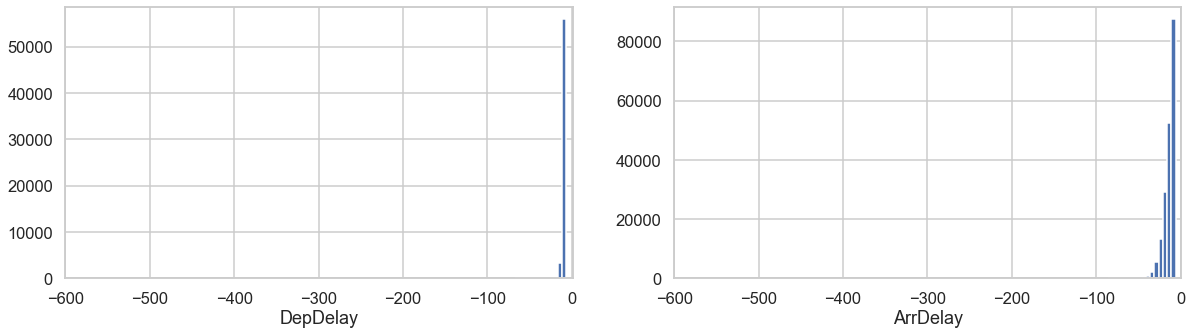

In [27]:
plt.figure(figsize = [20, 5])
#Distribution of the Departure Delay
plt.subplot(1, 2, 1)
#bin size of 5 minutes in the negative part.
bin_edges = np.arange(df_2008['DepDelay'].min()-5, -5, 5)
sns.distplot(df_2008['DepDelay'], bins = bin_edges, kde = False,
            hist_kws = {'alpha' : 1});
plt.xlim(-600, 1);
#Distribution of the Arrival Delay
plt.subplot(1, 2, 2)
#bin size of 5 minutes in the negative part.
bin_edges = np.arange(df_2008['ArrDelay'].min()-5, -5, 5)
sns.distplot(df_2008['ArrDelay'], bins = bin_edges, kde = False,
            hist_kws = {'alpha' : 1}); 
plt.xlim(-600, 1);

These are the distributions of the positive parts.

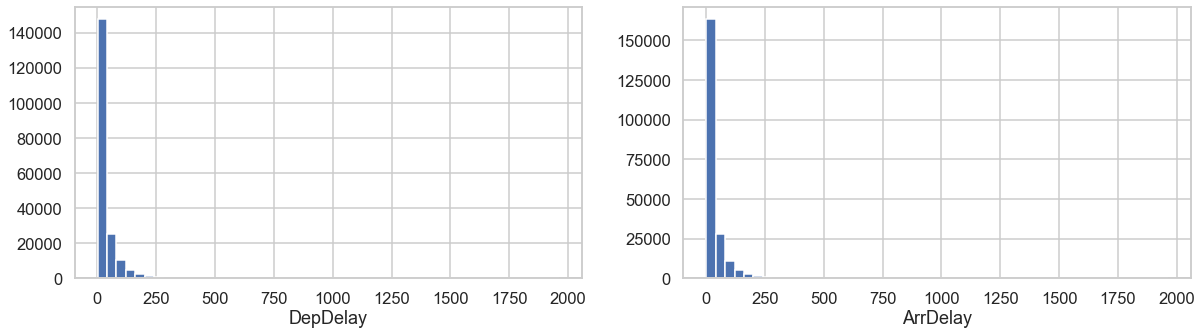

In [28]:
plt.figure(figsize = [20, 5])
#Distribution of the Departure Delay
plt.subplot(1, 2, 1)
#bin size of 40 minutes
bin_edges = np.arange(1, df_2008['DepDelay'].max()+40, 40)
sns.distplot(df_2008['DepDelay'], bins = bin_edges, kde = False,
            hist_kws = {'alpha' : 1});
#Distribution of the Arrival Delay
plt.subplot(1, 2, 2)
#bin size of 40 minutes
bin_edges = np.arange(1, df_2008['ArrDelay'].max()+40, 40)
sns.distplot(df_2008['ArrDelay'], bins = bin_edges, kde = False,
            hist_kws = {'alpha' : 1}); 

In general we can see that the shape is highly skewed to the right in both cases. Most of the values are smaller than an hour but there are a few values greater than a day. This cases are really special, but I don't go to do anything with them by the moment. Surely they are real and they must be considered. 

The range of values is very large, but most of them are close to 0. I am going to draw the graphs limiting the range of the axis.

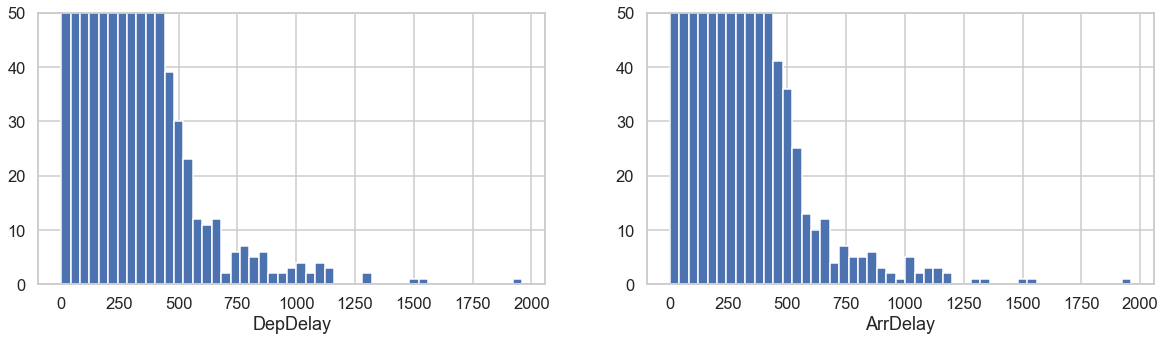

In [29]:
#The same graph as before but wiht a limit of 50 in the y-axis.
plt.figure(figsize = [20, 5])
#Distribution of the Departure Delay
plt.subplot(1, 2, 1)
#bin size of 40 minutes
bin_edges = np.arange(1, df_2008['DepDelay'].max()+40, 40)
sns.distplot(df_2008['DepDelay'], bins = bin_edges, kde = False,
            hist_kws = {'alpha' : 1});
plt.ylim(0, 50) 
#Distribution of the Arrival Delay
plt.subplot(1, 2, 2)
#bin size of 40 minutes
bin_edges = np.arange(1, df_2008['ArrDelay'].max()+40, 40)
sns.distplot(df_2008['ArrDelay'], bins = bin_edges, kde = False,
            hist_kws = {'alpha' : 1});
plt.ylim(0, 50);

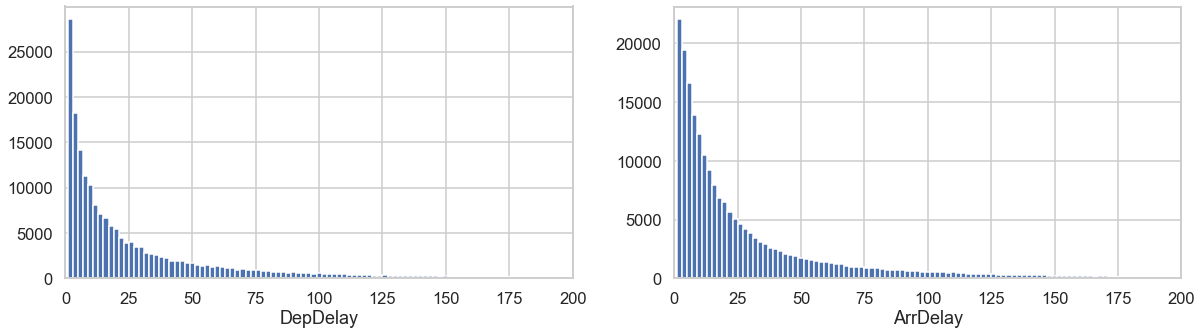

In [30]:
#The same graph as before but wiht a limit of 200 in the x-axis.
plt.figure(figsize = [20, 5])
#Distribution of the Departure Delay
plt.subplot(1, 2, 1)
#bin size of 2 minutes
bin_edges = np.arange(1, df_2008['DepDelay'].max()+2, 2)
sns.distplot(df_2008['DepDelay'], bins = bin_edges, kde = False,
            hist_kws = {'alpha' : 1});
plt.xlim(0, 200); 
#Distribution of the Arrival Delay
plt.subplot(1, 2, 2)
#bin size of 2 minutes
bin_edges = np.arange(1, df_2008['ArrDelay'].max()+2, 2)
sns.distplot(df_2008['ArrDelay'], bins = bin_edges, kde = False,
            hist_kws = {'alpha' : 1});
plt.xlim(0, 200);

Another thing that I have notice is that in the case of the Departure Delay there are some periodical peaks every five minutes. This must be surely because in some airport they update this delay from five to five minutes.

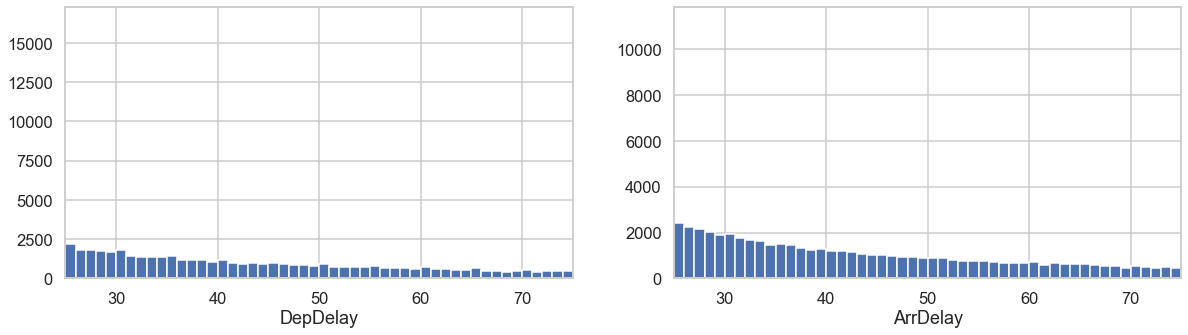

In [31]:
plt.figure(figsize = [20, 5])
#Distribution of the Departure Delay
plt.subplot(1, 2, 1)
#bin size of 1 minutes
bin_edges = np.arange(1, df_2008['DepDelay'].max()+1, 1)
sns.distplot(df_2008['DepDelay'], bins = bin_edges, kde = False,
            hist_kws = {'alpha' : 1})
plt.xlim(25, 75);
#Distribution of the Arrival Delay
plt.subplot(1, 2, 2)
#bin size of 1 minutes
bin_edges = np.arange(1, df_2008['ArrDelay'].max()+1, 1)
sns.distplot(df_2008['ArrDelay'], bins = bin_edges, kde = False,
            hist_kws = {'alpha' : 1})
plt.xlim(25, 75);

I am going to see also the distribution of the other delay causes. In these cases all the values are positive. We are going to use this variables to calculate the total delay. So it is important that they are positive because to work with negative delays can be confusing.

In [32]:
print(df_2008['CarrierDelay'].max(), df_2008['CarrierDelay'].min())
print(df_2008['WeatherDelay'].max(), df_2008['WeatherDelay'].min())
print(df_2008['NASDelay'].max(), df_2008['NASDelay'].min())
print(df_2008['SecurityDelay'].max(), df_2008['SecurityDelay'].min())
print(df_2008['LateAircraftDelay'].max(), df_2008['LateAircraftDelay'].min())

1951.0 0.0
1098.0 0.0
992.0 0.0
199.0 0.0
1303.0 0.0


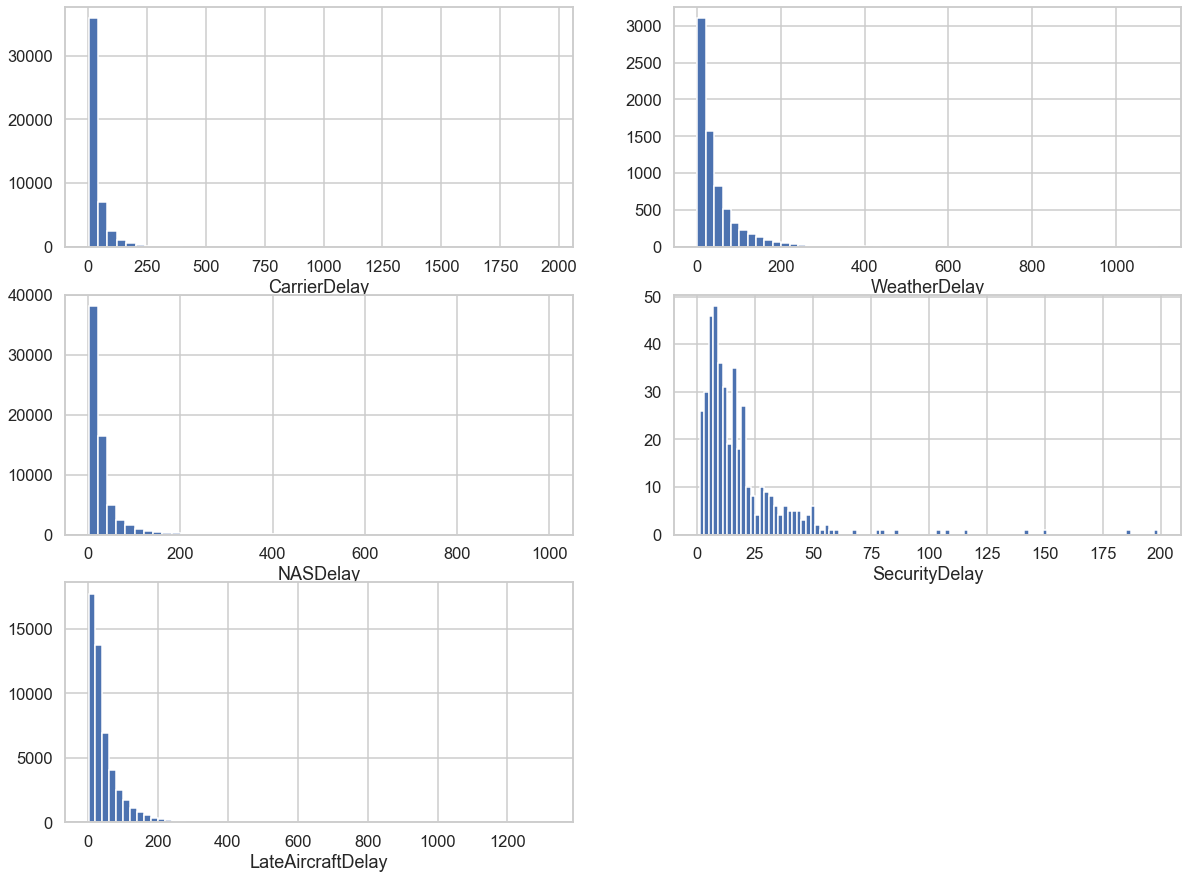

In [33]:
plt.figure(figsize = [20, 15])
#Distribution of the Carrier Delay
plt.subplot(3, 2, 1)
bin_edges = np.arange(1, df_2008['CarrierDelay'].max()+40, 40)
sns.distplot(df_2008['CarrierDelay'], bins = bin_edges, kde = False,
            hist_kws = {'alpha' : 1});

#Distribution of the Weather Delay
plt.subplot(3, 2, 2)
bin_edges = np.arange(1, df_2008['WeatherDelay'].max()+20, 20)
sns.distplot(df_2008['WeatherDelay'], bins = bin_edges, kde = False,
            hist_kws = {'alpha' : 1});

#Distribution of the NAS Delay
plt.subplot(3, 2, 3)
bin_edges = np.arange(1, df_2008['NASDelay'].max()+20, 20)
sns.distplot(df_2008['NASDelay'], bins = bin_edges, kde = False,
            hist_kws = {'alpha' : 1});

#Distribution of the Security Delay
plt.subplot(3, 2, 4)
bin_edges = np.arange(1, df_2008['SecurityDelay'].max()+2, 2)
sns.distplot(df_2008['SecurityDelay'], bins = bin_edges, kde = False,
            hist_kws = {'alpha' : 1});

#Distribution of the Late Aircraft Delay
plt.subplot(3, 2, 5)
bin_edges = np.arange(1, df_2008['LateAircraftDelay'].max()+20, 20)
sns.distplot(df_2008['LateAircraftDelay'], bins = bin_edges, kde = False,
            hist_kws = {'alpha' : 1});

These distibutions are very similar to the departure and the arrival delay distributions. They are also highly skewed to the right. We can see that the Security Delays are very rear comparing with the others. 

I am going to draw them in more detail limiting the x-axis.

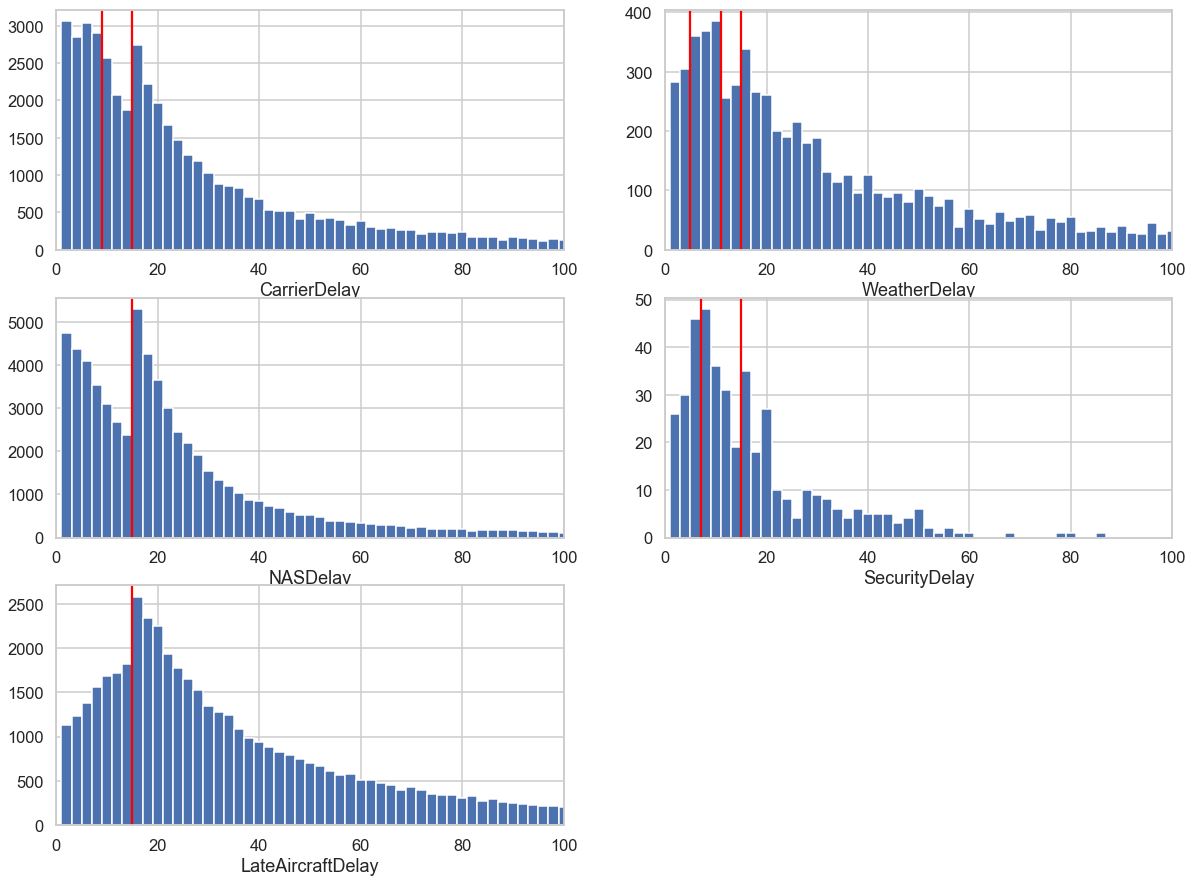

In [34]:
plt.figure(figsize = [20, 15])
#Distribution of the Carrier Delay
plt.subplot(3, 2, 1)
bin_edges = np.arange(1, df_2008['CarrierDelay'].max()+2, 2)
sns.distplot(df_2008['CarrierDelay'], bins = bin_edges, kde = False,
            hist_kws = {'alpha' : 1});
#red line in 15 minutes
plt.axvline(x= 15, color='r');
#red line in 9 minutes
plt.axvline(x= 9, color='r');
plt.xlim(0, 100)

#Distribution of the Weather Delay
plt.subplot(3, 2, 2)
bin_edges = np.arange(1, df_2008['WeatherDelay'].max()+2, 2)
sns.distplot(df_2008['WeatherDelay'], bins = bin_edges, kde = False,
            hist_kws = {'alpha' : 1});
#red line in 15 minutes
plt.axvline(x= 15, color='r');
#red line in 5 minutes
plt.axvline(x= 5, color='r');
#red line in 10 minutes
plt.axvline(x= 11, color='r');
plt.xlim(0, 100)

#Distribution of the NAS Delay
plt.subplot(3, 2, 3)
bin_edges = np.arange(1, df_2008['NASDelay'].max()+2, 2)
sns.distplot(df_2008['NASDelay'], bins = bin_edges, kde = False,
            hist_kws = {'alpha' : 1});
#red line in 15 minutes
plt.axvline(x= 15, color='r');
plt.xlim(0, 100)

#Distribution of the Security Delay
plt.subplot(3, 2, 4)
bin_edges = np.arange(1, df_2008['SecurityDelay'].max()+2, 2)
sns.distplot(df_2008['SecurityDelay'], bins = bin_edges, kde = False,
            hist_kws = {'alpha' : 1});
#red line in 15 minutes
plt.axvline(x= 15, color='r');
#red line in 7 minutes
plt.axvline(x= 7, color='r');
plt.xlim(0, 100)

#Distribution of the Late Aircraft Delay
plt.subplot(3, 2, 5)
bin_edges = np.arange(1, df_2008['LateAircraftDelay'].max()+2, 2)
sns.distplot(df_2008['LateAircraftDelay'], bins = bin_edges, kde = False,
            hist_kws = {'alpha' : 1});
#red line in 15 minutes
plt.axvline(x= 15, color='r');
plt.xlim(0, 100);

Except in the carrier delay all of them have a peak in 15 minutes, but we can see that the distributions are quite different from each other.

In the case of the carrier delay it seems that there is a flat distribution in the first eight minutes, then decrease gradually until the fifteen minutes where it has a great increment of cases and then decrease gradually again.

In the case of weather delay there is also a some flat like distribution between the five and the ten minutes, then decrease until the fifteen minutes where again there is a peak, but in this case isolated.

The NAS delay has like two sawteeth. One starting in cero, it decrease gradually until fifteen minutes where it has a peak an then decrease gradually again.

The security delay has a great peak in seven or eight minutes and then decreas gradually wiht the exception of the fifteen minutes where it has an isolated peak.

And finally, the late aricraft delay increase gradually the number of cases until 15 minutes where it has a great step to decrease gradually after it.

Apart of the nature of the delays, the crieteria to update them seems to be fifferent depending of the case, but fifteen minutes seems to be a common criteria in many of them.

Besides this if we see the weather delay in more detail we can see small peak every five minutes (In the original file with all the samples it was more clear).

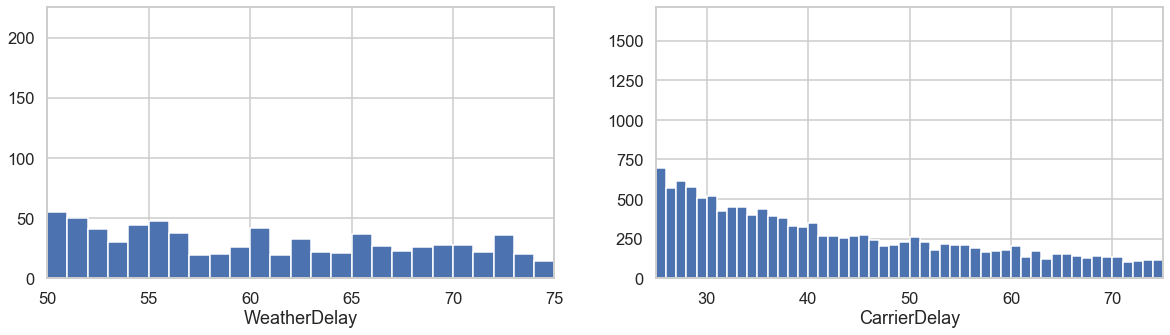

In [35]:
##Distribution detail of the Weather Delay
plt.figure(figsize = [20, 5])
plt.subplot(1, 2, 1)
bin_edges = np.arange(1, df_2008['WeatherDelay'].max()+1, 1)
sns.distplot(df_2008['WeatherDelay'], bins = bin_edges, kde = False,
            hist_kws = {'alpha' : 1})
plt.xlim(50, 75);
##Distribution detail of the Weather Delay
plt.subplot(1, 2, 2)
bin_edges = np.arange(1, df_2008['CarrierDelay'].max()+1, 1)
sns.distplot(df_2008['CarrierDelay'], bins = bin_edges, kde = False,
            hist_kws = {'alpha' : 1})
plt.xlim(25, 75);

This can be the resason why we saw these peaks in the departure delay.

Now we are going to see the percentages and the number of cancellations by type.

In [36]:
df_2008.CancellationCode.unique()

array([nan, 'A', 'B', 'C'], dtype=object)

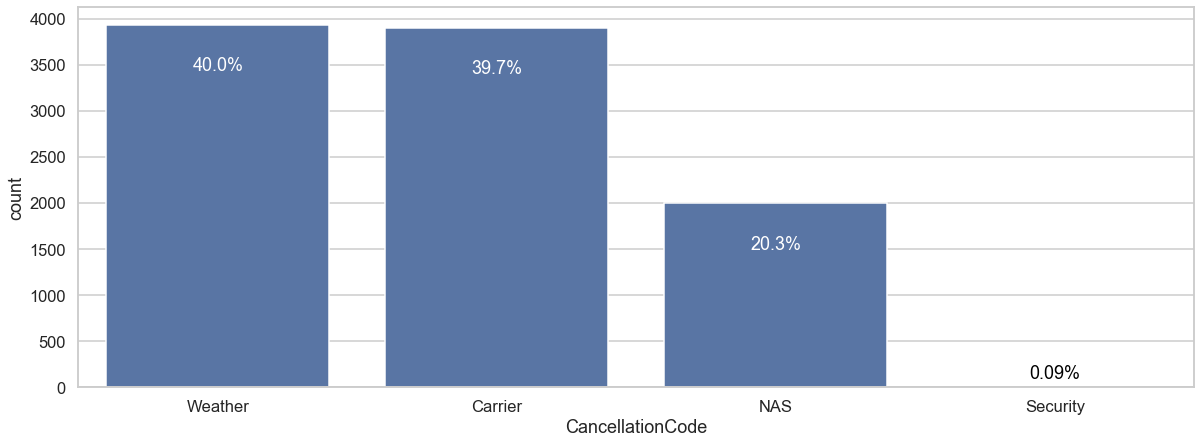

In [37]:
base_color = sns.color_palette()[0]
fig = plt.figure(figsize=(20,7))

#Add annotations
n_points = df_2008.query('Cancelled == True').shape[0]
cat_counts = df_2008['CancellationCode'].value_counts()

cancelled_order = ['B', 'A', 'C', 'D']
ordered_cancelled = pd.api.types.CategoricalDtype(ordered = True, categories = cancelled_order)
df_2008['CancellationCode'] = df_2008['CancellationCode'].astype(ordered_cancelled)

sns.countplot(data = df_2008, x = 'CancellationCode', color = base_color)

#Get the current tick locations and labels
locs, labels = plt.xticks()


#Loop through each pair of locations and labels
for loc, label in zip(locs, labels):
    # get the text property for the label to get the correct count
    
    
    
    if label.get_text() == 'D':
        #Print the annotation above the top of the bar in the case D
        #0.09% is the percentage that I have obtained from the original file
        plt.text(loc, 100, '0.09%', fontsize=18, ha = 'center', color = 'black')
        #pct_string = '{:0.3f}%'.format(100*count/n_points)
        #plt.text(loc, count+100, pct_string, fontsize=18, ha = 'center', color = 'black')
    else:
        count = cat_counts[label.get_text()]
        #Print the annotation just below the top of the bar
        pct_string = '{:0.1f}%'.format(100*count/n_points)
        plt.text(loc, count-500, pct_string, fontsize=18, ha = 'center', color = 'w')
plt.xticks(locs, ('Weather', 'Carrier', 'NAS', 'Security'));

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

All the variables related with delays and elapsed time are highly right skewed and long-tailed. The point that are strange to me are the negative values of the arrival and departure delays, anyway the surely are normal values or they have a reason to be negative, so I didn't do anything with them. There are also values that are vey large, but there are surely a reason for this, so we are going also to contemplete these values.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

The percentage of cancellation types are completly normal. So I didn't do anything

## Bivariate Exploration



* We have up to 13 numeric variables in this dataset. This means that we have a lot of combinations to investigate posible correlations. I am going to start drawing a matrix plot of correlations between them.

List of categorical and numerical variables:

In [38]:
numeric_vars = ['ActualElapsedTime', 'CRSElapsedTime', 'AirTime' ,'Distance', 
                'ArrDelay', 'DepDelay', 
                'LateAircraftDelay' ,'CarrierDelay', 'NASDelay', 'WeatherDelay', 'SecurityDelay', 
                'TaxiOut', 'TaxiIn']
categoric_vars = ['Month', 'DayOfWeek', 'UniqueCarrier']

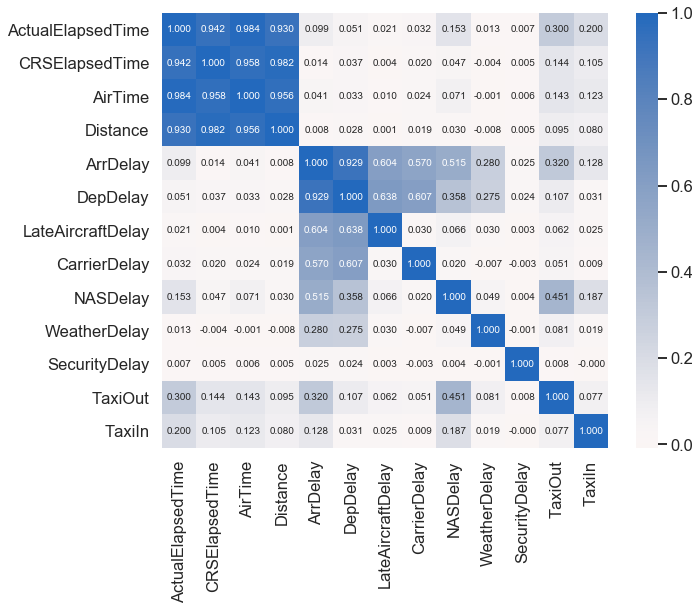

2.667735300000004

In [39]:
# correlation plot
start = timer()
plt.figure(figsize = [10, 8])
sns.heatmap(df_2008[numeric_vars].corr(), annot = True, fmt = '.3f',
           cmap = 'vlag_r', center = 0)
plt.show()
end = timer()
end-start

In this plot we can see that there is a very strong correlation between the variables `ActualElapsedTime`, `CRSElapsedTime`, `AirTime` and `Distance`.This is obvious and quite normal taking into account that the most important variable in the necessary time for a flight is the distance, so this variables are very close between them. We can't extract many new conclusions from that.

We can also see that `DepDelay` and `ArrDelay` are also strongly correlated, which seems also quite normal.

On the other hand we can apreciate a correlation, not so strongly, between `ArrDelay` and `DepDelay` with the delay causes variables `LateAircraftDelay` ,`CarrierDelay`, `NASDelay`, `WeatherDelay` and `SecurityDelay`. This is normal too according with the linear regression analysis that we did at the start of the work, but is intersting to see that the `NASDelay` is more correlated with the `ArrDelay` than with the `DepDelay`, while the correlation between the other causes is similar. Maybe the `NASDelay` is more relevant in the arrivals than in the departures.

Finally we observe also a certain correlation between  the `TaxiOut` and `NASDelay`. And taking into account that `NASDelay` has some correlation with `ArrDelay`, `TaxiOut` has also some correlation with `ArrDelay`. Correlation does not mean causation, but according with the closeness of this variables, this could indicate that `TaxiOut` is an important cause of the NAS delays. And if we also consider that `TaxiOut` is more correlated with `ArrDelay` than with `DepDelay`, probably `TaxiOut` could be the most important cause in the difference between `ArrDelay` and `DepDelay`.


* Now I am going to analyze the relationship between this variables with **scatter plots**, but taking into account the great number of variables, instead of drawing a single PairGrid I have decided to divide the matrix in three parts. I have divided the variables in two lists and then I have draw a PairGrid with the scatter plots of the first list, another one for the second list and a third one with the plots between the two lists. 

I have started creating a dataframe with 10000 samples and the two lists of variables.

In [40]:
start = timer()
random.seed(30)
samples = np.random.choice(df_2008.shape[0], 10000, replace = False)
df_sample = df_2008.loc[samples,:]
end = timer()
end-start

0.05479400000001533

5.957497700000033

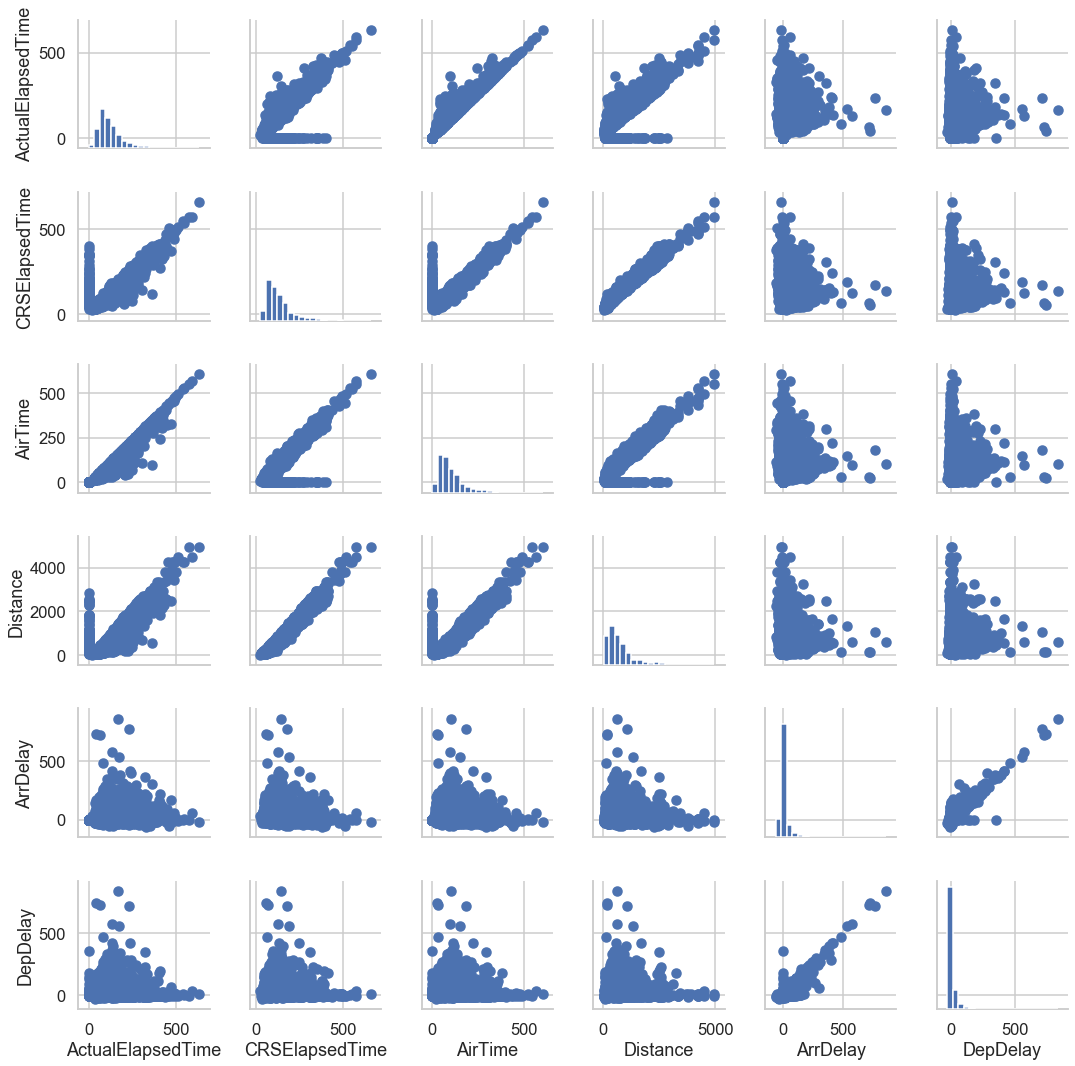

In [42]:
#scatter plots for the list_vars1
start = timer()
g = sns.PairGrid(data = df_sample, x_vars=list_vars1, y_vars = list_vars1)
g = g.map_diag(plt.hist, bins = 20);
g.map_offdiag(plt.scatter)
end = timer()
end-start

12.763134200000025

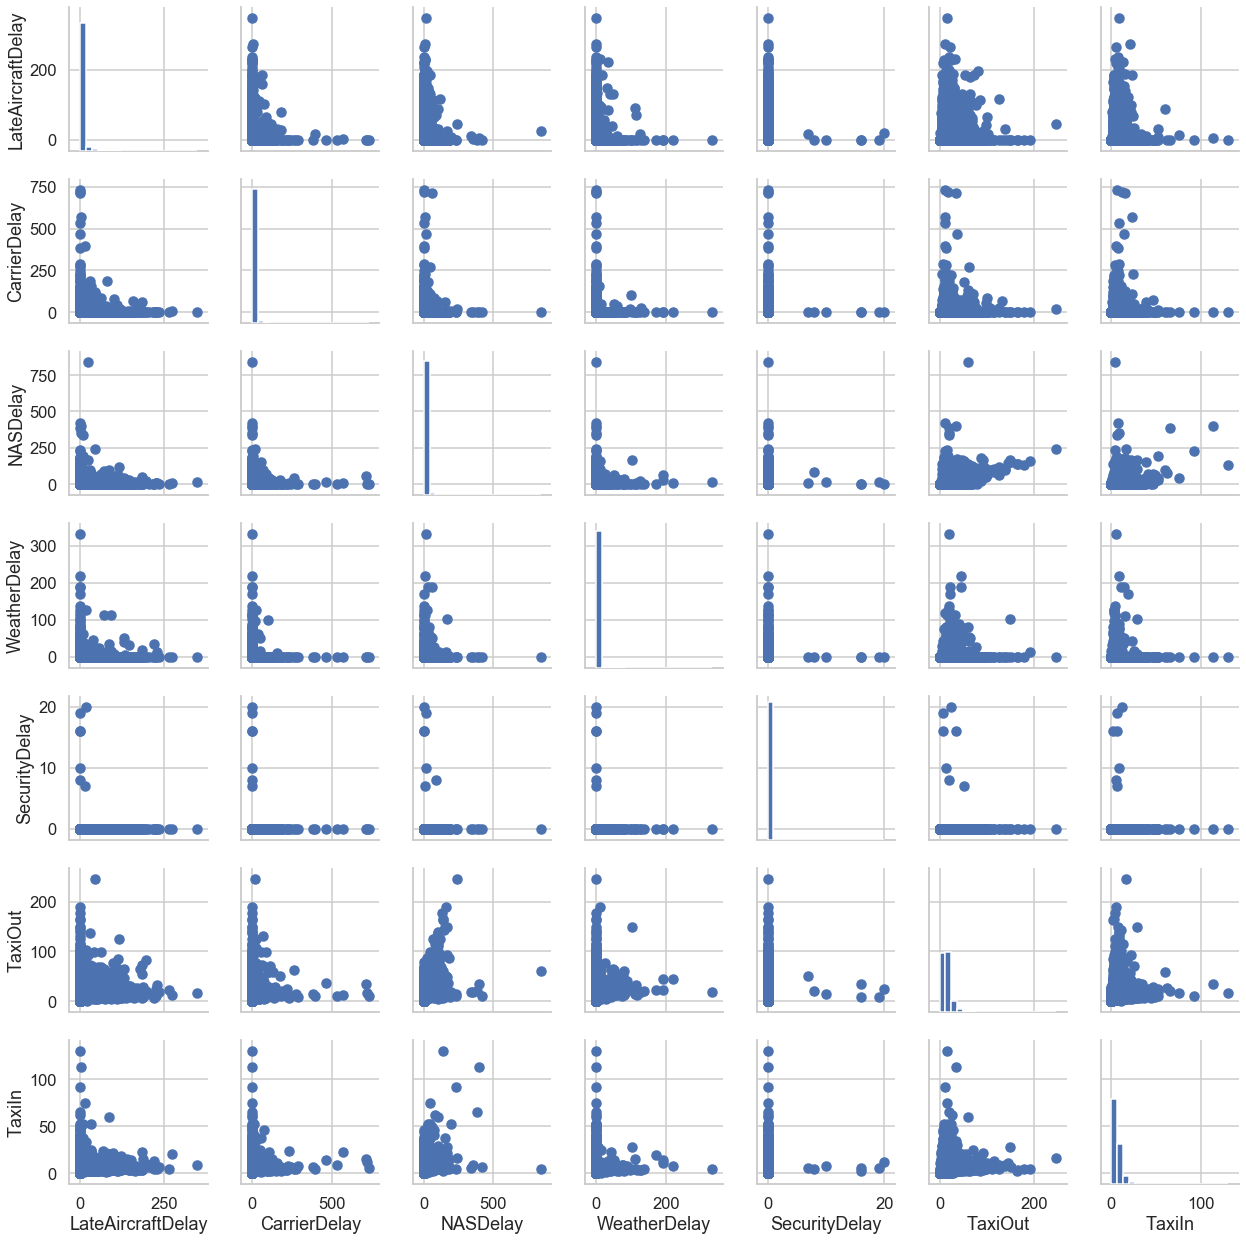

In [43]:
#scatter plots for the list_vars2
start = timer()
g = sns.PairGrid(data = df_sample, x_vars=list_vars2, y_vars = list_vars2)
g = g.map_diag(plt.hist, bins = 20);
g.map_offdiag(plt.scatter)
end = timer()
end-start

10.058286600000088

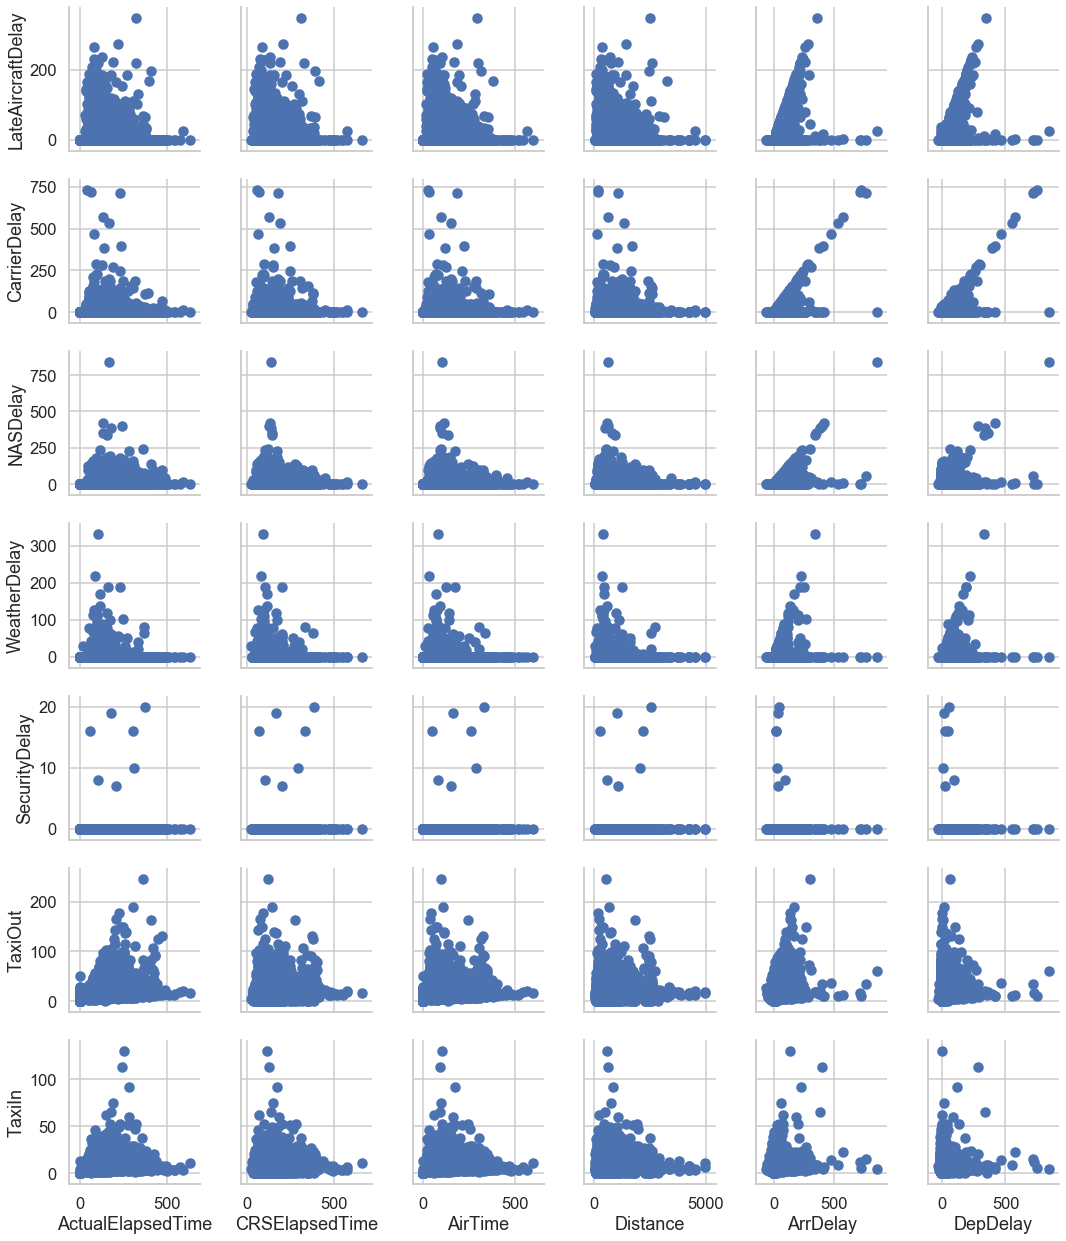

In [44]:
#scatter plots between list_vars1 and list_vars2
start = timer()
g = sns.PairGrid(data = df_sample, x_vars=list_vars1, y_vars = list_vars2)
g = g.map(plt.scatter)
end = timer()
end-start

* There are a lot of plots to analyze, but we can easily see that there are some repeated patterns that we can investigate more precisely in bigger plots and with more samples. For example there is a clearly linear relationship between the variables: `ActualElapsedTime`, `CRSElapsedTime`, `AirTime` and `Distance`. At first sight it seems pretty normal, but we are going to see one of them more closely.

We define a dataset with 50000 samples to draw this scatter plots.

In [45]:
start = timer()
np.random.seed(25)
samples = np.random.choice(df_2008.shape[0], 50000, replace = False)
df_sample = df_2008.loc[samples,:]
end = timer()
end-start

0.18940780000002633

1.8351982000000362

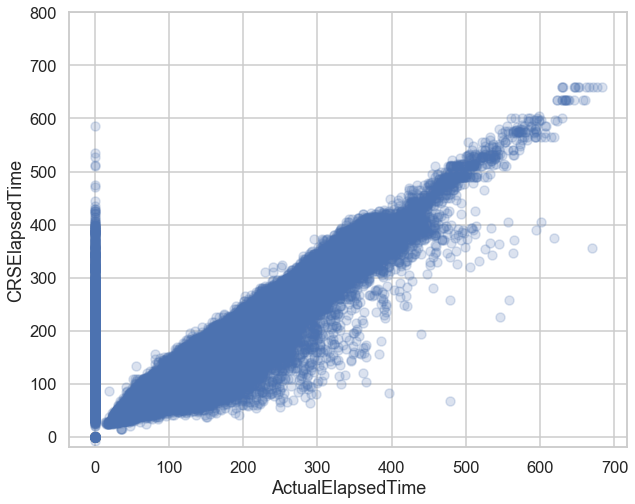

In [46]:
#scatter plot between 'ActualElapsedTime' and 'CRSElapsedTime'.
start = timer()
plt.figure(figsize = [10, 8])
plt.scatter(data = df_2008, x = 'ActualElapsedTime', y = 'CRSElapsedTime', alpha=0.2)
plt.ylim(-20, 800)
plt.xlabel('ActualElapsedTime')
plt.ylabel('CRSElapsedTime')
end = timer()
end-start

We can identify in this graph some different patterns.

    * The vertical line at x=0 are obviously the cancelled fligths. Those flights that had been schedulled but finally did not take off.
 
    * Most of the rest the flights follow a linear patter described by x = y, but we can see clearly that for an schedulled time smaller than 400 minutes the spread of the actual elapsed time is clearly bigger. It seems that the delays are bigger in this range of time, but this can be because the dataset doesn't have some many information about the delays for the longer trips, not because they don't actually have so much delay. We can't know that.
 
    * We can see also some outliers. Schedulled delays negative? It is strange. And there are some long flights that seem to have a limit in the schedulled time around 400 minutes (I saw this in the original file, in this sample it is not so clear).

In [47]:
df_2008.query('CRSElapsedTime < 0')[['Date',
                                       'DepTime',
                                       'CRSDepTime',
                                       'ArrTime',
                                       'CRSArrTime',
                                       'CRSElapsedTime',
                                       'ActualElapsedTime',
                                       'UniqueCarrier',
                                       'Origin',
                                       'Dest',
                                       'Distance', 'Cancelled']]

Date  DepTime  CRSDepTime  ArrTime  CRSArrTime  CRSElapsedTime  \
238385  2008-02-03     1747        1638        0        1729            -9.0   

        ActualElapsedTime UniqueCarrier Origin Dest  Distance  Cancelled  
238385                0.0            OO    ORD  IND       177          0

* There is also a linear relationship pattern between the variables `ArrDelay` and `DepDelay`. I am going to expand the plot to see it better:

4.153307599999948

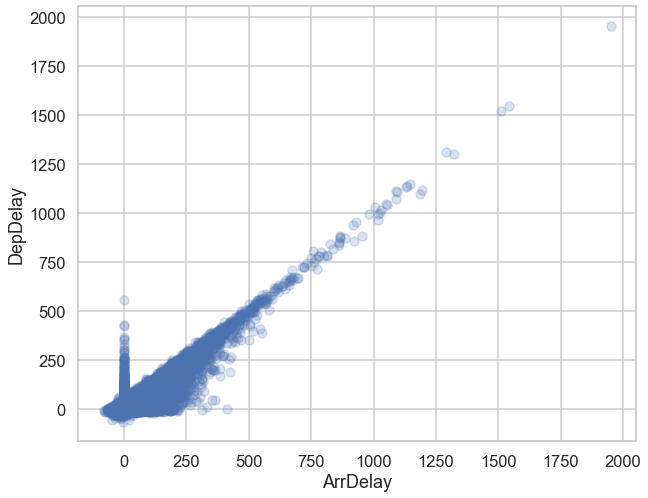

In [48]:
#scatter plot between ArrDelay and DepDelay
start = timer()
plt.figure(figsize = [10, 8])
plt.scatter(data = df_2008, x = 'ArrDelay', y = 'DepDelay', alpha=0.2);
plt.xlabel('ArrDelay')
plt.ylabel('DepDelay')
end = timer()
end-start

1.8800655999999663

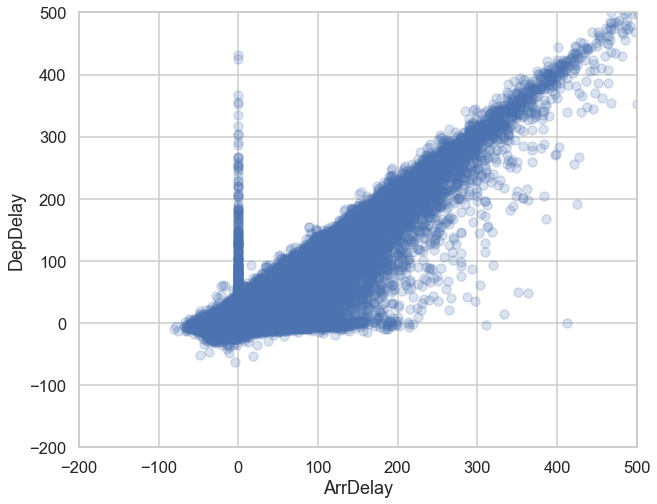

In [49]:
#enlargment of the delays around 0.
start = timer()
plt.figure(figsize = [10, 8])
plt.scatter(data = df_2008, x = 'ArrDelay', y = 'DepDelay', alpha=0.2);
plt.xlabel('ArrDelay')
plt.ylabel('DepDelay')
plt.xlim(-200, 500)
plt.ylim(-200, 500)
end = timer()
end-start

In [50]:
df_2008.query('DepDelay < -200')[['Date',
                               'DepTime',
                               'CRSDepTime',
                               'ArrTime',
                               'CRSArrTime',
                               'DepDelay',
                               'ArrDelay',
                               'UniqueCarrier',
                               'Origin',
                               'Dest',
                               'Distance']]

Empty DataFrame
Columns: [Date, DepTime, CRSDepTime, ArrTime, CRSArrTime, DepDelay, ArrDelay, UniqueCarrier, Origin, Dest, Distance]
Index: []

These two variables describe a linear relationship one to one in the upper side. And for small delays we could draw a line y=a+x describing an upper limit for the samples. Is like the `ArrDelay` were always smaller than `DepDelay` more a constant.
When the delays are not enormous, less than 500 minutes, the behaviour is normal, I mean that the Arrival Delay tends to be greater than the Departure Delay. But for the biggest delays the two values tend to be equal. We saw before that the main difference between the two delays was their relation with `NASDelay`. This could indicate that `NASDelay` is not usually the cause of the delays of several hours.


* Another shape that it is repeated a lot in the first matrix is the one between `ActualElapsedTime` and `DepDelay`. We can find this shape also between `DepDelay` and `ArrDelay` with `ActualElapsedTime`, `CRSElapsedTime`, `AirTime` and `Distance`.

1.8790448999999398

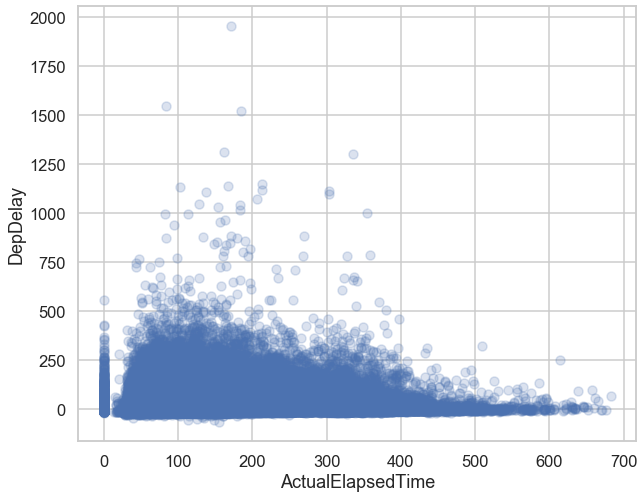

In [51]:
start = timer()
plt.figure(figsize = [10, 8])
plt.scatter(data = df_2008, x = 'ActualElapsedTime', y = 'DepDelay', alpha=0.2);
plt.xlabel('ActualElapsedTime')
plt.ylabel('DepDelay')
end = timer()
end-start

C:\Users\jesus\Anaconda3\envs\analysis\lib\site-packages\numpy\linalg\linalg.py:1974: RuntimeWarning:

invalid value encountered in greater



161.36817199999996

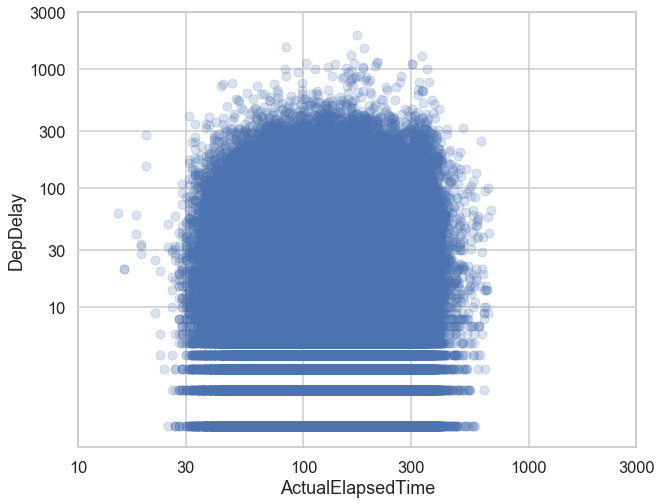

In [52]:
start = timer()
def log_trans(x, inverse = False):
    if not inverse:
        return np.log10(x)
    else:
        return np.power(10, x)
plt.figure(figsize = [10, 8])
sns.regplot(df_2008['ActualElapsedTime'].apply(log_trans), df_2008['DepDelay'].apply(log_trans), 
            scatter=True, fit_reg=True, scatter_kws={'alpha':0.2})
tick_locs = [10, 30, 100, 300, 1000, 3000]
plt.xticks(log_trans(tick_locs), tick_locs)
plt.yticks(log_trans(tick_locs), tick_locs)
end = timer()
end-start

This twoo variables tend to have a log-normal distribution and if we change the scale of the two axis to logaritmic we can see that there is no relatinship between them.

* In the second matrix we can see an interesting shape between `TaxiOut` and `TaxiIn` with `NASDelay`.

1.891301599999906

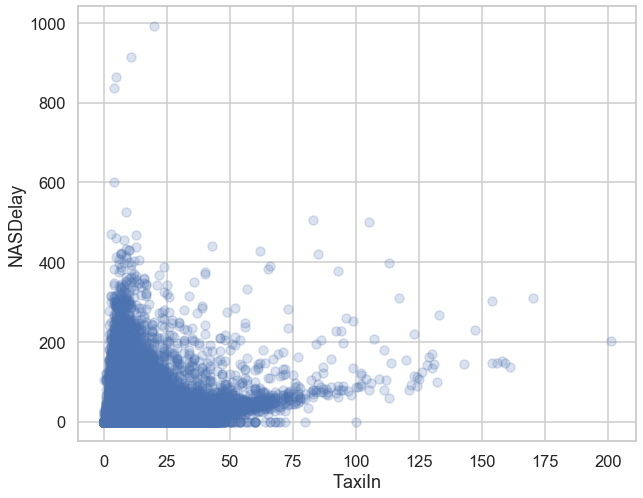

In [53]:
start = timer()
plt.figure(figsize = [10, 8])
plt.scatter(data = df_2008, x = 'TaxiIn', y = 'NASDelay', alpha=0.2);
plt.xlabel('TaxiIn')
plt.ylabel('NASDelay')
end = timer()
end-start

1.799810999999977

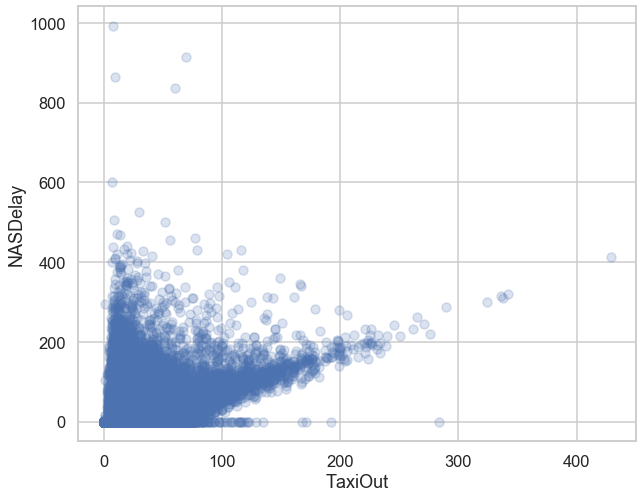

In [54]:
start = timer()
plt.figure(figsize = [10, 8])
plt.scatter(data = df_2008, x = 'TaxiOut', y = 'NASDelay', alpha=0.2);
plt.xlabel('TaxiOut')
plt.ylabel('NASDelay')
end = timer()
end-start

In this picture is showed that when `TaxiOut` is small there are other causes that influence in `NASDelay` but for big values of `TaxiOut` this seems to be the principal influence on it. With `TaxiIn` it happens something similar, but `TaxiIn` usually has smaller values than `TaxiOut` and the relation is not so evident.

* Finally this is the relationship between `ArrDelay` and `NASDelay`. We can see a linear relationship one to one for big values of `NASDelay`. It is similar to the relationship between `DepDelay` and `NASDelay` but not so clear in this case.

1.8472514999999703

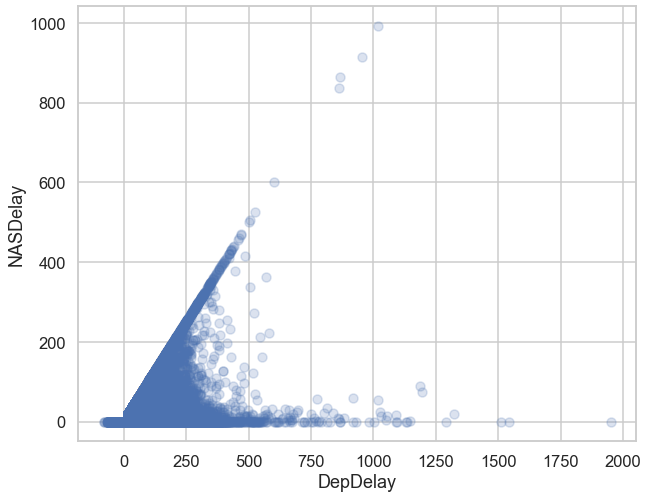

In [55]:
start = timer()
plt.figure(figsize = [10, 8])
plt.scatter(data = df_2008, x = 'ArrDelay', y = 'NASDelay', alpha=0.2);
plt.xlabel('DepDelay')
plt.ylabel('NASDelay')
end = timer()
end-start

* Now I am going to do the analysis of the categorical variables. In this part of the analysis I am going to work basicly with violin plots and box plots. I am going to use also various dataframes: `df_2008` when I need to work with values per flight and `df_carriers` when I want to work with means of the values per day. Remember that in this dataframe we have grouped the data by carrier and day, so it is easy to get the mean by day and we can work with the data of more years than 2008.

The categorical variables available in the dataset are `DayOfWeek`, `Month`, `Cancelled`, `Diverted` and `CancellationCause`. I am going to focus my research in the first two variables and I would like to add another one, the `geographical region`. To do this I am going to divide the airports in five geografical regions: Alaska, Hawaaii, West, Center and East. We have the coordenates of the airports in the dataframe `df_airports_inf`.

I start making the division in de `df_airports_inf` dataset. First, I have chosen three rectangles for this regions:

In [56]:
#coordenates for the region of Alaska
alaska = {'point1': [73, -180],
          'point2': [73, -129],
          'point3': [50, -129],
          'point4': [50, -180]}

#coordenates for the region of Hawaii
hawaii = {'point1': [25, -180],
          'point2': [25, -140],
          'point3': [10, -140],
          'point4': [10, -180]}

#coordenates for the region for the continent region
continent = {'point1': [50, -135],
             'point2': [50, -62],
             'point3': [22.5, -77],
             'point4': [22.5, -125]}

#coordenates to divide the continent in three regions: West, Center, East
first_division_north = continent['point1'][1]+(continent['point2'][1]-continent['point1'][1])/3
first_division_south = continent['point4'][1]+(continent['point3'][1]-continent['point4'][1])/3-1
second_division_north = continent['point1'][1]+(continent['point2'][1]-continent['point1'][1])/3*2
second_division_south = continent['point4'][1]+(continent['point3'][1]-continent['point4'][1])/3*2-2

#polygon that defines the central area in the continent.
polygon_center = Polygon([(continent['point1'][0], first_division_north),
                          (continent['point1'][0], second_division_north),
                          (continent['point4'][0], second_division_south),
                          (continent['point4'][0], first_division_south)])

Now I have assigned each airport to each region in `df_airports_inf`.

In [57]:
#function to asigante a label to each point
def region_label (row):
    point = Point(row['lat'], row['long'])
    if row['lat'] > 50 :
        return 'Alaska'
    elif row['lat'] < 25 and row['long'] < -135:
        return 'Hawaii'
    elif row['lat'] < 50 and row['long'] > -135 and row['long'] < -110:
        return 'West'
    elif polygon_center.contains(point):
        return 'Center'
    else:
        return 'East'
    
#adds the column 'region' to df_airports_inf with the region information
df_airports_inf['region'] = df_airports_inf.apply (lambda row: region_label(row), axis=1)

I am going to convert `region` to a categorical ordinal variable in order to see them bether in the visualizations.

In [58]:
#convert region into a categorical ordinal variable.
ordered_region = pd.api.types.CategoricalDtype(ordered = True, categories = ['Alaska', 'Hawaii', 'West', 'Center', 'East'])
df_airports_inf['region'] = df_airports_inf['region'].astype(ordered_region)

These are all the airports drawed in a map wiht their regions:

In [59]:
#define a figure with a scatter_map plot. y=lat, y=long and different colors by region. 
fig = px.scatter_mapbox(df_airports_inf, lat="lat", lon="long", color="region", text = 'airport', zoom=1.9)

#draws a polygon in the continet area
fig.add_trace(go.Scattermapbox(
    mode = "lines",
    lon = [continent['point1'][1], continent['point2'][1],
           continent['point3'][1], continent['point4'][1], continent['point1'][1]],
    lat = [continent['point1'][0], continent['point2'][0],
           continent['point3'][0], continent['point4'][0], continent['point1'][0]],
    line = dict(width = 1,color = 'red')))

#draws the two vertical lines that divide the continent in three parts
fig.add_trace(go.Scattermapbox(
    mode = "lines",
    lon = [first_division_north,
           first_division_south],
    lat = [continent['point2'][0],continent['point3'][0]],
    line = dict(width = 1,color = 'red')))
fig.add_trace(go.Scattermapbox(
    mode = "lines",
    lon = [second_division_north,
           second_division_south],
    lat = [continent['point2'][0],continent['point3'][0]],
    line = dict(width = 1,color = 'red')))

#draws a polygon in Alaska
fig.add_trace(go.Scattermapbox(
    mode = "lines",
    lon = [alaska['point1'][1], alaska['point2'][1],
           alaska['point3'][1], alaska['point4'][1], alaska['point1'][1]],
    lat = [alaska['point1'][0], alaska['point2'][0],
           alaska['point3'][0], alaska['point4'][0], alaska['point1'][0]],
    line = dict(width = 1,color = 'red')))

#draws a polygon in Hawaii
fig.add_trace(go.Scattermapbox(
    mode = "lines",
    lon = [hawaii['point1'][1], hawaii['point2'][1],
           hawaii['point3'][1], hawaii['point4'][1], hawaii['point1'][1]],
    lat = [hawaii['point1'][0], hawaii['point2'][0],
           hawaii['point3'][0], hawaii['point4'][0], hawaii['point1'][0]],
    line = dict(width = 1,color = 'red')))

#select the layout options
fig.update_layout(
    mapbox_style="white-bg",
    mapbox_layers=[
        {
            "below": 'traces',
            "sourcetype": "raster",
            "source": [
                "https://basemap.nationalmap.gov/arcgis/rest/services/USGSImageryOnly/MapServer/tile/{z}/{y}/{x}"
            ]
        }
      ])

#visualization paramiters: center, zoom, etc.
fig.update_layout(
    showlegend=False,
    margin ={'l':20,'t':20,'b':20,'r':20},
    mapbox = {
        'style': "stamen-terrain",
        'center': {'lon': continent['point1'][1]+(continent['point2'][1]-continent['point1'][1])/2,
                   'lat':  continent['point1'][0]+(continent['point2'][0]-continent['point1'][0])/2},
        'zoom': 1.9})

fig.show()

In [60]:
df_airports_inf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 8 columns):
iata       3376 non-null object
airport    3376 non-null object
city       3364 non-null object
state      3364 non-null object
country    3376 non-null object
lat        3376 non-null float64
long       3376 non-null float64
region     3376 non-null category
dtypes: category(1), float64(2), object(5)
memory usage: 188.2+ KB


In [61]:
#number of airports by region
df_airports_inf.region.value_counts()

East      1402
Center    1165
West       522
Alaska     263
Hawaii      24
Name: region, dtype: int64

In the first place I am going to analyze the data by flight so I will use the dataframe `df_2008`. We must remember that this dataframe is a sample of 50000 rows of the original file.

I add a new colum with the sum of all the main delays.

In [62]:
df_2008['TotalDelay'] = df_2008['CarrierDelay'] +\
                        df_2008['WeatherDelay'] +\
                        df_2008['NASDelay'] +\
                        df_2008['SecurityDelay'] +\
                        df_2008['LateAircraftDelay']

Now I define four groups of variables to work with:

    * numeric_vars_duration: numerical variables for duration of trips and distance.
    * numeric_vars_delay: numerical variables for delays.
    * numeric_log_vars_duration: names used for the logaritm of numeric_vars_duration when they are necessary.
    * numeric_log_vars_delay: names used for the logaritm of numeric_vars_delay when they are necessary.

In [63]:
numeric_vars_duration = ['ActualElapsedTime', 'CRSElapsedTime', 'AirTime' ,'Distance']

In [64]:
numeric_vars_delay = ['TotalDelay', 'ArrDelay', 'DepDelay', 
                      'LateAircraftDelay' ,'CarrierDelay', 'NASDelay', 'WeatherDelay', 'SecurityDelay', 
                      'TaxiOut', 'TaxiIn']

In [65]:
numeric_log_vars_duration = ['Log_ActualElapsedTime', 'Log_CRSElapsedTime', 'Log_AirTime' ,'Log_Distance']

In [66]:
numeric_log_vars_delay = ['Log_TotalDelay', 'Log_ArrDelay', 'Log_DepDelay', 
                          'Log_LateAircraftDelay' ,'Log_CarrierDelay', 'Log_NASDelay', 'Log_WeatherDelay', 'Log_SecurityDelay', 
                          'Log_TaxiOut', 'Log_TaxiIn']

I make a copy of df_2008 because we have to change the 0 values to avoid problems with the logarithmic

In [67]:
df_2008_copy = df_2008.query('Cancelled == 0')

I change the value 0 by 1 to avoid the problem of the logarithm of 0.

In [68]:
num = df_2008_copy._get_numeric_data()
num[num == 0] = 1

I add the new columns to the dataframe with the logarithm of the numerical variables of delays.

In [69]:
# compute the logarithm of delays
def log_trans(x, inverse = False):
    """ quick function for computing log and power operations """
    if not inverse:
        return np.log10(x)
    else:
        return np.power(10, x)
    
#add new columns with the logarithm of the variables of delays
df_2008_copy['Log_TotalDelay'] = df_2008_copy['TotalDelay'].apply(log_trans)
df_2008_copy['Log_ActualElapsedTime'] = df_2008_copy['ActualElapsedTime'].apply(log_trans)
df_2008_copy['Log_CRSElapsedTime'] = df_2008_copy['CRSElapsedTime'].apply(log_trans)
df_2008_copy['Log_AirTime'] = df_2008_copy['AirTime'].apply(log_trans)
df_2008_copy['Log_Distance'] = df_2008_copy['Distance'].apply(log_trans)
df_2008_copy['Log_ArrDelay'] = df_2008_copy['ArrDelay'].apply(log_trans)
df_2008_copy['Log_DepDelay'] = df_2008_copy['DepDelay'].apply(log_trans)
df_2008_copy['Log_LateAircraftDelay'] = df_2008_copy['LateAircraftDelay'].apply(log_trans)
df_2008_copy['Log_CarrierDelay'] = df_2008_copy['CarrierDelay'].apply(log_trans)
df_2008_copy['Log_NASDelay'] = df_2008_copy['NASDelay'].apply(log_trans)
df_2008_copy['Log_WeatherDelay'] = df_2008_copy['WeatherDelay'].apply(log_trans)
df_2008_copy['Log_SecurityDelay'] = df_2008_copy['SecurityDelay'].apply(log_trans)
df_2008_copy['Log_TaxiOut'] = df_2008_copy['TaxiOut'].apply(log_trans)
df_2008_copy['Log_TaxiIn'] = df_2008_copy['TaxiIn'].apply(log_trans)



C:\Users\jesus\Anaconda3\envs\analysis\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jesus\Anaconda3\envs\analysis\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jesus\Anaconda3\envs\analysis\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

I am going to add a column with the region of the airport of departure. 

In [70]:
#I add the colum region to the dataframe with the information in df_airports_inf
df_2008_copy['Region'] = df_2008_copy.Origin.map(df_airports_inf.set_index('iata')['region'].to_dict())
#convert region into a categorical ordinal variable.
ordered_region = pd.api.types.CategoricalDtype(ordered = True, categories = ['Alaska', 'Hawaii', 'West', 'Center', 'East'])
df_2008_copy['Region'] = df_2008_copy['Region'].astype(ordered_region)
df_2008_copy['Region'].unique()

C:\Users\jesus\Anaconda3\envs\analysis\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jesus\Anaconda3\envs\analysis\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



[West, East, Center, Hawaii, Alaska]
Categories (5, object): [Alaska < Hawaii < West < Center < East]

The first thing that I have tried is to draw boxplots and violin plots from the numerical variables in function of the day of week and month, but with the data per flight I didn't obtain any conclusion, even with in a logarithm scale. All the figures seem very similar.

The plots that can be interesting are the violin plots in logarithmic scale of the numeric_vars_duration per region:

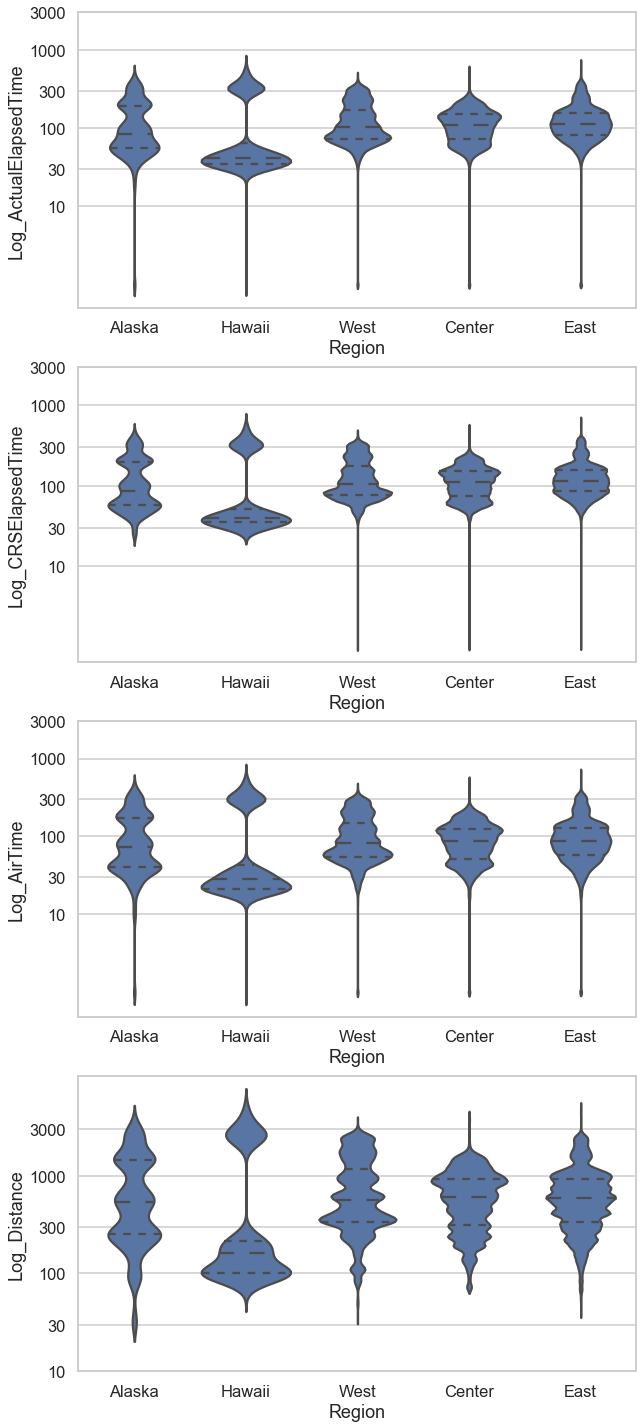

In [71]:
#violin plots of 'Log_ActualElapsedTime', 'Log_CRSElapsedTime', 'Log_AirTime' ,'Log_Distance' per 'region'
fig, ax = plt.subplots(ncols = 1, nrows = len(numeric_log_vars_duration) , figsize = [10,25])
default_color = sns.color_palette()[0]

for i in range(len(numeric_log_vars_duration)):
    var = numeric_log_vars_duration[i]
    sns.violinplot(data = df_2008_copy, x = 'Region', y = var, ax = ax[i],
               color = default_color, inner = 'quartile')
    tick_locs = [10, 30, 100, 300, 1000, 3000]
    ax[i].set_yticks(log_trans([10, 30, 100, 300, 1000, 3000]))
    ax[i].set_yticklabels([10, 30, 100, 300, 1000, 3000])

plt.show()

We can see here some great differences between the shapes:
    * For example, Hawaii has two main different nodules. This is logical because they have two different types of traffic. The inner traffic between the islands and the flights to the continent, much more larger. 
    * Alaska has a shape elonged and quite uniform. It not exist a clear preference between short and log flights over 200 miles.
    * Between the three areas in the continent there are also some differences. The west region has the greater proportion of long flights, maybe influenced by the flights to Hawaii, but it has a clear increment in the first quartile.
    * The center and east regions are very simiral, but the East Region has small amount of flights in the upper side. ¿It Could be influenced by the proximity to Puerto Rico? Surealy they are long flights to the west coast.

* Now I am going to analyze with some boxplots the delays variables comparing the five regions, the days of the week and the months. I had not achieve any conlusion when I tried to do this using the values by flight. I am going to try now viewing the distribution of the means per day. The distribution of the means per day is not so skewed and it is not necessary to use the logarithm scale. 

The dataframe that I am going to use is df_origin because it has the means per day and I can get values for several years. I am going to select values since 2004 because the delays were collected since 2003.


In [72]:
#I add the comun region to the dataframe df_origins
df_origins['Region'] = df_origins.Origin.map(df_airports_inf.set_index('iata')['region'].to_dict())
#It groups by day an filter the data after 2004. 
df_origin_by_day = df_origins.query('Date >= "2004-01-01"').groupby(['Date', 'DayOfWeek', 'Region']).mean()
df_origin_by_day = df_origin_by_day.reset_index()

In [73]:
#It adds the column TotalDay with the sum of the delays.
df_origin_by_day['TotalDelay'] = df_origin_by_day['CarrierDelay'] +\
                             df_origin_by_day['WeatherDelay'] +\
                             df_origin_by_day['NASDelay'] +\
                             df_origin_by_day['SecurityDelay'] +\
                             df_origin_by_day['LateAircraftDelay']
#set an order to the geographical regions
ordered_region = pd.api.types.CategoricalDtype(ordered = True, categories = ['Alaska', 'Hawaii', 'West', 'Center', 'East'])
df_origin_by_day['Region'] = df_origin_by_day['Region'].astype(ordered_region)

* First I am going to draw the boxplots of the delays by region.

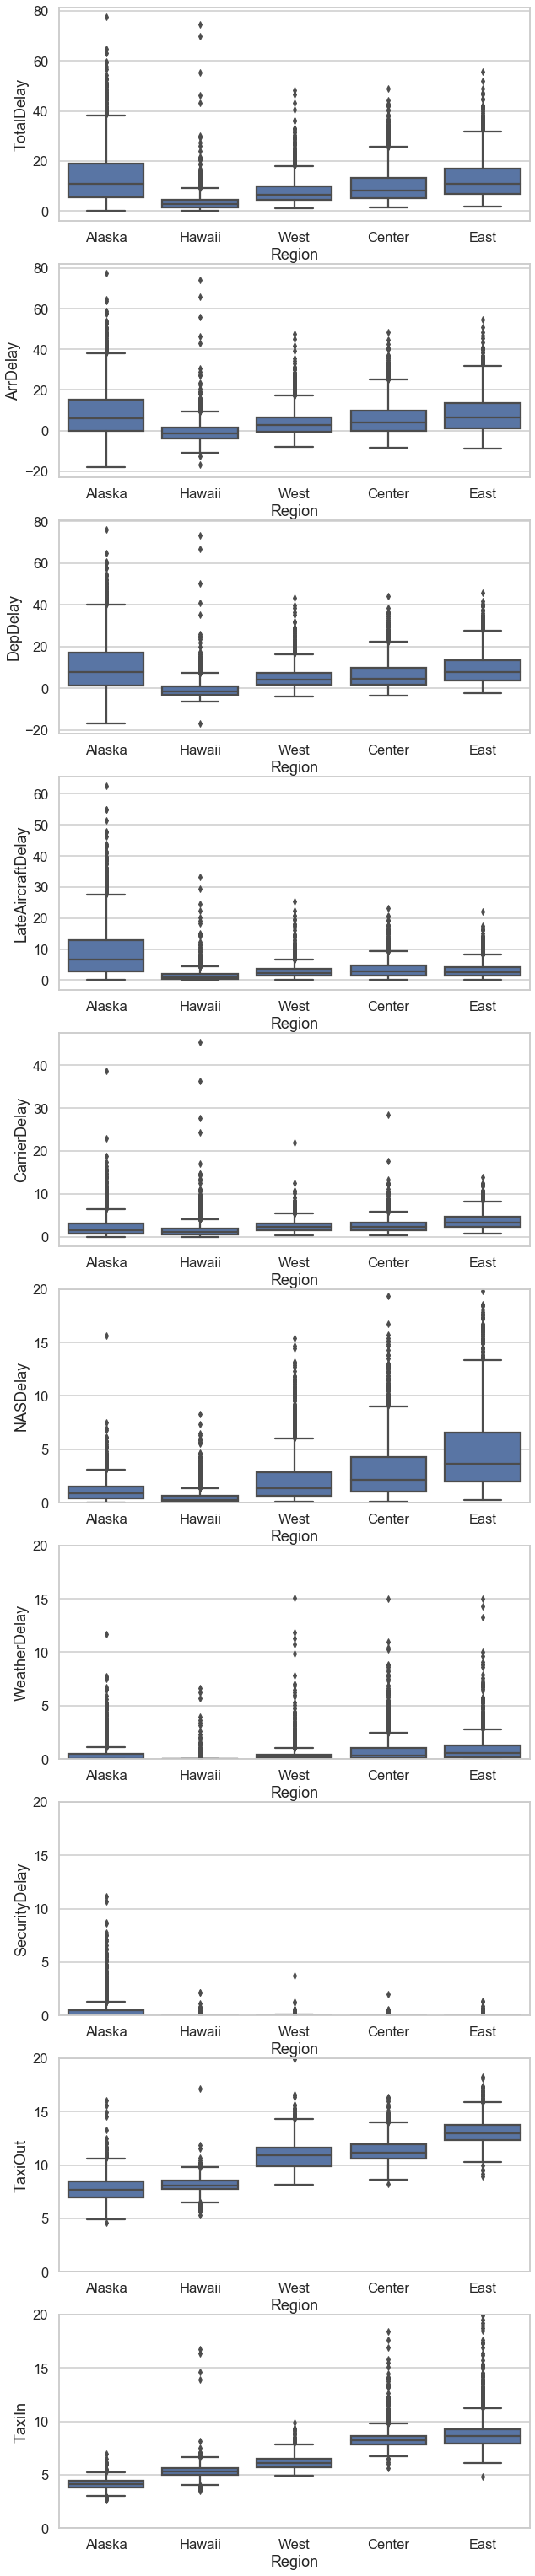

In [74]:
#It draws a list of boxplots for the variables numeric_vars_delay with the Region in the x-axis.
fig, ax = plt.subplots(ncols = 1, nrows = len(numeric_vars_delay) , figsize = [10,55])
default_color = sns.color_palette()[0]

for i in range(len(numeric_vars_delay)):
    var = numeric_vars_delay[i]
    sns.boxplot(data = df_origin_by_day, x = 'Region', y = var, ax = ax[i],
               color = default_color)

ax[5].set_ylim(0,20)
ax[6].set_ylim(0,20)
ax[7].set_ylim(0,20)
ax[8].set_ylim(0,20)
ax[9].set_ylim(0,20)
plt.show()

    * In these plots is showed that Alaska has the biggest probles in terms of `TotalDelay`, but this problems are caused      basicly by the `LateAircraftDelay` and the `SecurityDelay`, although the Security Delays are very small.
    * Anyway, despite the cold weather Alaska don't have especial problems with this type of delay. The worst in this case is the East Region maybe the hurricans season is more important in this aspect.
    * In all the other causes the East Region and the Center Region seems to have the worst behaviour.
    * Te East Region is also the worst in reference to the `NAS Delay`, `TaxiIn` and `TaxiOut` delays. But we saw that there is certain correlation between `TaxiIn` and `TaxiOut` and `NAS Delay`, so it seems logical.
    * Hawaii is the region with smaller delays in general.


* These are de boxplots of the delay variables by day of week:

In [75]:
#Change the names of DayOfWeek
df_origin_by_day['DayOfWeek'] = df_origin_by_day['DayOfWeek'].map({1: 'Monday', 
                                                                   2: 'Tuesday',
                                                                   3: 'Wednesday',
                                                                   4: 'Thursday',
                                                                   5: 'Friday',
                                                                   6: 'Saturday',
                                                                   7: 'Sunday'})
#Set DayOfWeek as Categorical ordinal
ordered_day = pd.api.types.CategoricalDtype(ordered = True, categories = ['Monday', 
                                                                          'Tuesday', 
                                                                           'Wednesday', 
                                                                           'Thursday', 
                                                                           'Friday',
                                                                           'Saturday',
                                                                           'Sunday'])
df_origin_by_day['DayOfWeek'] = df_origin_by_day['DayOfWeek'].astype(ordered_day)

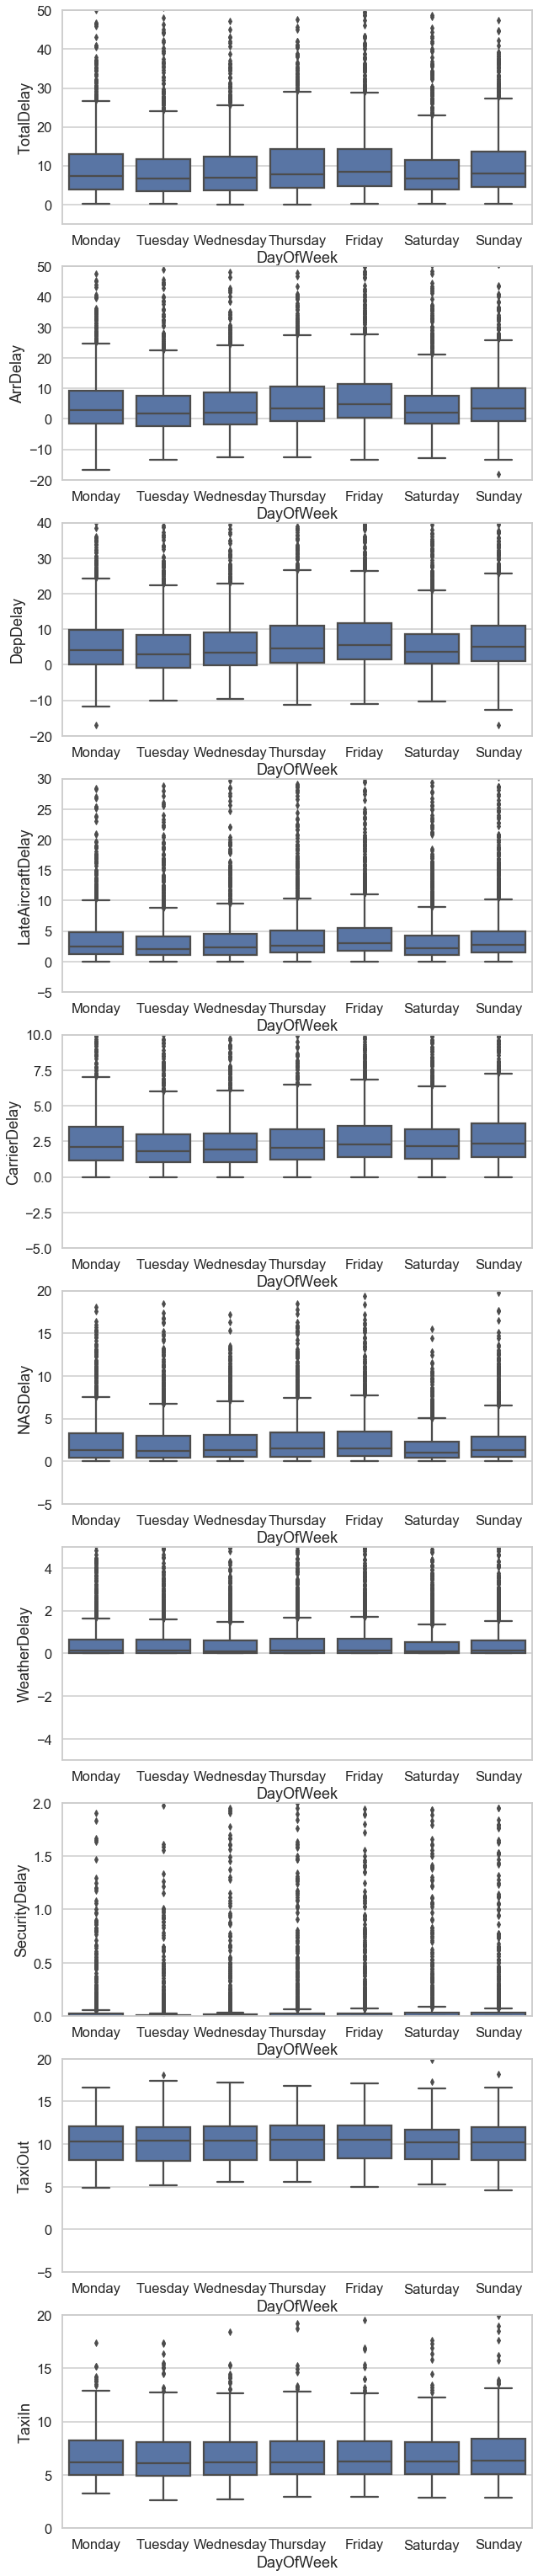

In [76]:


#Draws boxplots of the delay variables by Day of Week.
ylim=[[-5,50], [-20,50], [-20,40], [-5,30], [-5,10], [-5,20], [-5,5], [0,2], [-5,20], [0,20]]
fig, ax = plt.subplots(ncols = 1, nrows = len(numeric_vars_delay) , figsize = [10,55])
default_color = sns.color_palette()[0]

for i in range(len(numeric_vars_delay)):
    var = numeric_vars_delay[i]
    sns.boxplot(data = df_origin_by_day, x = 'DayOfWeek', 
                y = var, ax = ax[i], 
                color = default_color)
    
    ax[i].set_ylim(ylim[i])
plt.show();



According to these graphics, Thursday and Friday, seems to be the days with more delays followed by Mondays and Sundays, but there is not a cause that clearly stand out from others.

In [77]:
#Change the names of Months
df_origin_by_day['Month'] = df_origin_by_day['Month'].map({1: 'Jan', 2: 'Feb',
                                                           3: 'Mar', 4: 'Apr',
                                                           5: 'May',6: 'Jun',
                                                           7: 'Jul',8: 'Aug',
                                                           9: 'Sep',10: 'Oct',
                                                           11: 'Nov',12: 'Dec',})
#Set Month as Categorical ordinal
ordered_day = pd.api.types.CategoricalDtype(ordered = True, categories = ['Jan', 'Feb', 
                                                                           'Mar', 'Apr', 
                                                                           'May','Jun',
                                                                           'Jul','Aug',
                                                                           'Sep','Oct',
                                                                           'Nov','Dec'])
df_origin_by_day['Month'] = df_origin_by_day['Month'].astype(ordered_day)

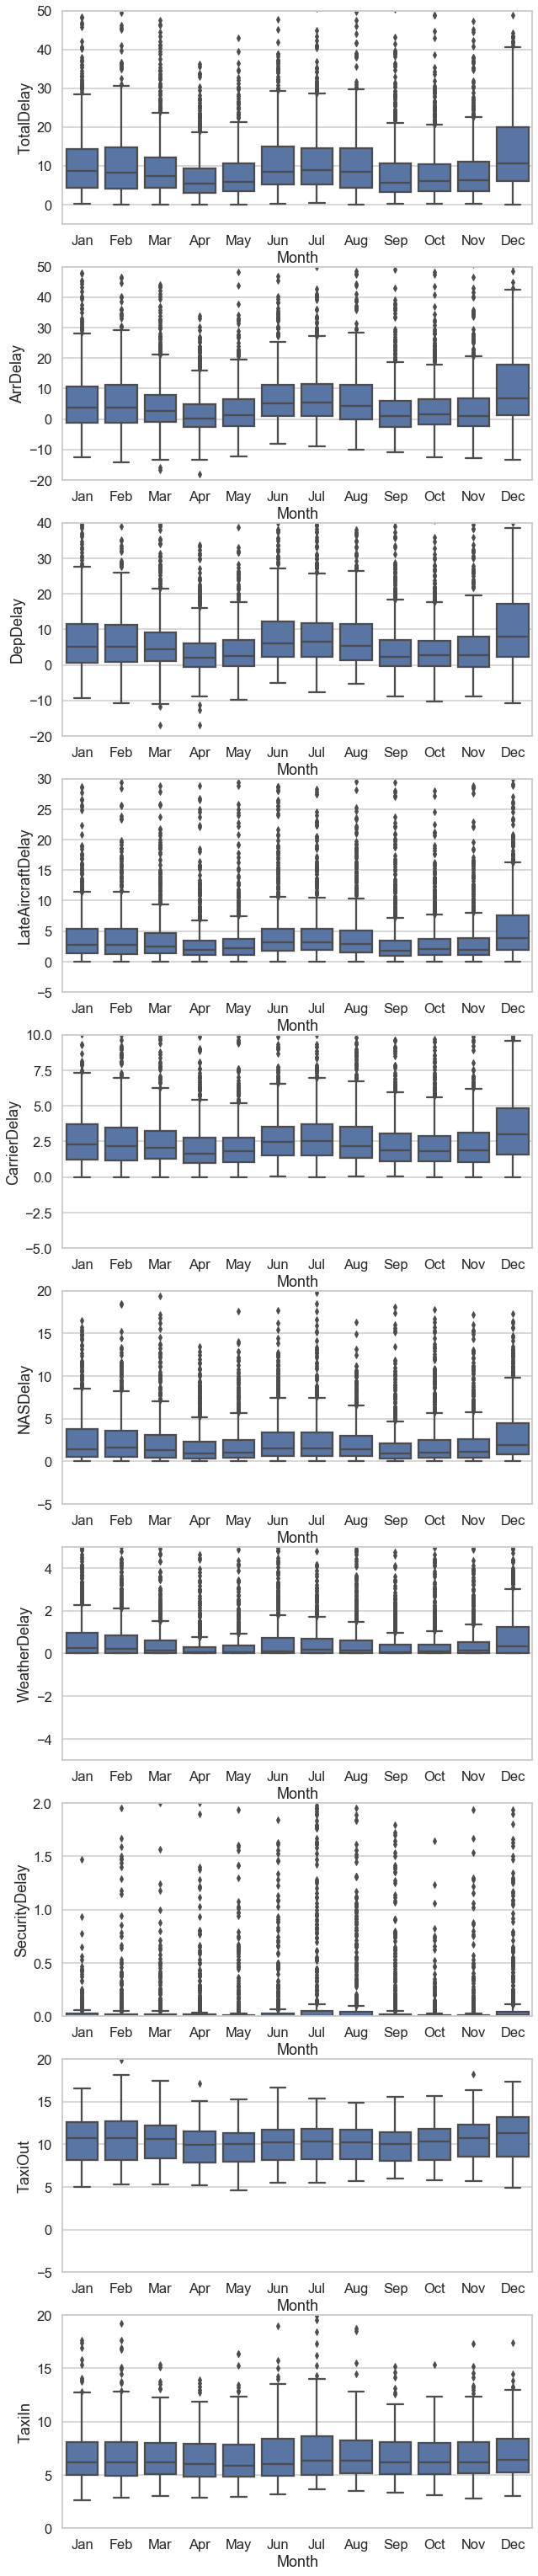

In [78]:
#draw boxplots for the distribution by months
ylim=[[-5,50], [-20,50], [-20,40], [-5,30], [-5,10], [-5,20], [-5,5], [0,2], [-5,20], [0,20]]
fig, ax = plt.subplots(ncols = 1, nrows = len(numeric_vars_delay) , figsize = [10,55])
default_color = sns.color_palette()[0]

for i in range(len(numeric_vars_delay)):
    var = numeric_vars_delay[i]
    sns.boxplot(data = df_origin_by_day, x = 'Month', y = var, ax = ax[i],
               color = default_color)
    ax[i].set_ylim(ylim[i])
plt.show()

    * In these pictures we can see that the worst month in terms of delays is December. It has the bigger median, quartiles, etc. All the main causes of delay are bigger in this month: the Weather Delay, the Carrier Delay and the NAS Delay.
    * The next worst months are June, July, August, Janury and February.
    * The best month in terms of delay was April.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

The main conclusions that we can extract from this analysis are:

* The distribution of the distance of the flights is very different between regions. 

This is normal because the nature of the flights vary a lot frome one region to another. For example in Hawaii there is a great difference between the flights from one island to another ant to the continent. 

* We have seen also that the main causes of delay vary a lot also from one region to another.

Some of this differences are normal, like the weather delays in the East Coast surely because the hurricans season. It is also normal that the weather delay is no so important in Hawaii.

Other differences are more difficult to explain. Like the importance of the NAS delay in the East Coast and the importance of the late aircraft and security delays in Alaska.

* Talking about periods of time we have seen that there are best days or months to travel than others, but the main causes of delay follow a similar patter. All of them tend to be bigger the same months or days. In some cases this patter is more obvious than in others, but in general terms they have a similar behaviour.

We can resume that the worst month in terms of delay is clearly December followed by June, July, August, February and January. The best month is April.

The worst days to travel are Thursday or Friday and the best days to travel are Tuesday or Saturday. 

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

I do not have established a priority between the features. I basicly have analyzed how the different delays are influenced by the region, day of week and the month.

## Multivariate Exploration


So far we have analyzed mainly what is the behaviour of the different variables of delay depending on the categorical variables `Region`, `Month` and `DayOfWeek` and how the delays are related between them. The next logical step is to investigate what is the evolution of the delays in each reagion along the different months and days of week. 
To do this I am going to use the same dataframe `df_origins` tha I have used in the steps before. The graph that I am going to use is the catplot from seaborn.

In [79]:
#we recover the original data fo df_origins, filter by year and group by Region and DayOfWeek
df_origin_by_day = df_origins.query('Date >= "2004-01-01"').groupby([ 'Region', 'DayOfWeek']).agg({'Count': 'sum'})


In [80]:
#It create a column with the percentage of flights in a day per week. For each region
df_origin_by_day = df_origins.query('Date >= "2004-01-01"').groupby([ 'Region', 'DayOfWeek']).agg({'Count': 'sum'})
df_origin_by_day_pcts = df_origin_by_day.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))


In [81]:
#reset the index and rename de column Count.
df_origin_by_day_pcts = df_origin_by_day_pcts.reset_index()
df_origin_by_day_pcts = df_origin_by_day_pcts.rename(columns = {'Count' : 'Percentage_Origin'})

In [82]:
#Change the name of the days
df_origin_by_day_pcts['DayOfWeek'] = df_origin_by_day_pcts['DayOfWeek'].map({1: 'Monday', 
                                                                               2: 'Tuesday',
                                                                               3: 'Wednesday',
                                                                               4: 'Thursday',
                                                                               5: 'Friday',
                                                                               6: 'Saturday',
                                                                               7: 'Sunday'})
#set an order to the geographical regions
ordered_region = pd.api.types.CategoricalDtype(ordered = True, categories = ['Alaska', 'Hawaii', 'West', 'Center', 'East'])
df_origin_by_day_pcts['Region'] = df_origin_by_day_pcts['Region'].astype(ordered_region)

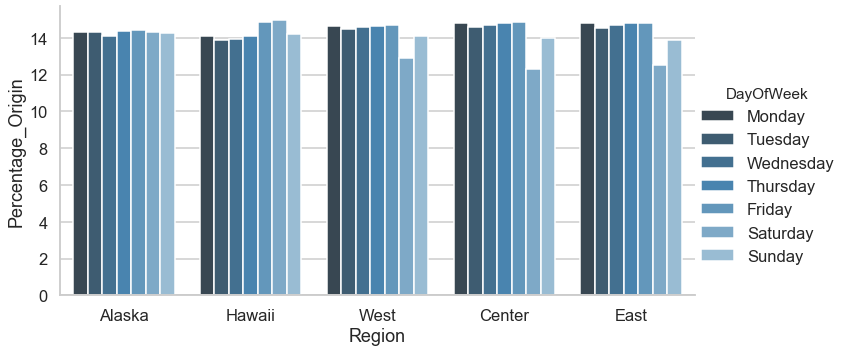

In [83]:
sns.set_palette("Blues_d", 7);

g = sns.catplot(x='Region', y='Percentage_Origin', 
                   hue='DayOfWeek', data=df_origin_by_day_pcts, 
                   kind='bar', height=5, aspect=2, legend_out=True)

In [84]:
df_origin_by_month = df_origins.query('Date >= "2004-01-01"').groupby([ 'Region', 'Month']).agg({'Count': 'sum'})
df_origin_by_month_pcts = df_origin_by_month.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))
df_origin_by_month_pcts = df_origin_by_month_pcts.rename(columns = {'Count' : 'Percentage_Origin'})

In [85]:
df_origin_by_month_pcts = df_origin_by_month_pcts.reset_index()
df_origin_by_month_pcts['Month'] = df_origin_by_month_pcts['Month'].map({1: 'January', 
                                                                         2: 'February',
                                                                         3: 'March',
                                                                         4: 'April',
                                                                         5: 'May',
                                                                         6: 'June',
                                                                         7: 'July',
                                                                         8: 'August',
                                                                         9: 'September',
                                                                         10: 'October',
                                                                         11: 'November',
                                                                         12: 'December'})

#set an order to the geographical regions
ordered_region = pd.api.types.CategoricalDtype(ordered = True, categories = ['Alaska', 'Hawaii', 'West', 'Center', 'East'])
df_origin_by_month_pcts['Region'] = df_origin_by_month_pcts['Region'].astype(ordered_region)

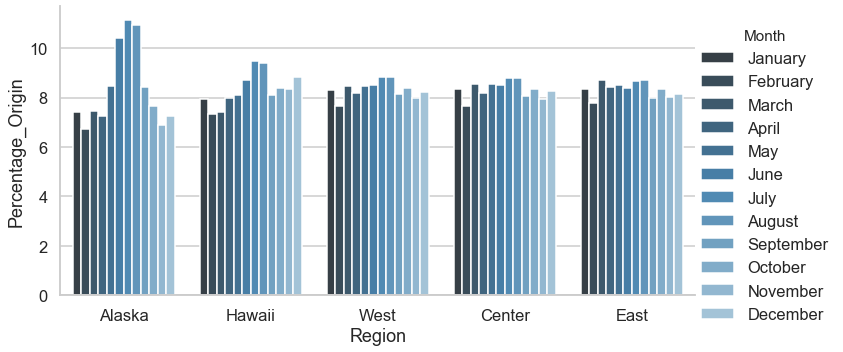

In [86]:
sns.set_palette("Blues_d", 12);

g = sns.catplot(x='Region', y='Percentage_Origin', 
                   hue='Month', data=df_origin_by_month_pcts, 
                   kind='bar', height=5, aspect=2, legend_out=True)

    * From the pictures above we can conclude that Alaska has a different behavior than the other regions. They travel a lot more in summer than in winter, this may explay why they don't have especial problems with the weather delay. On the     other hand its traffic is almost the same along the week, while in the other regions we found that is bigger Friday and Saturday in Hawaii and smaller the Saturday in the rest.


* Finally, as we did in the other analysis, we can investigate the delays for each region and its evolution along the week and the year. The procedure is similar to the before cases.

In [87]:
#we get a new copy of tthe dataset df_origins filtered by year and grouped bu region and day of week
df_origin_by_day = df_origins.query('Date >= "2004-01-01"').groupby([ 'Region', 'DayOfWeek']).mean()
df_origin_by_day =df_origin_by_day.reset_index()
#It changes the name of the days
df_origin_by_day['DayOfWeek'] = df_origin_by_day['DayOfWeek'].map({1: 'Monday', 
                                                                   2: 'Tuesday',
                                                                   3: 'Wednesday',
                                                                   4: 'Thursday',
                                                                   5: 'Friday',
                                                                   6: 'Saturday',
                                                                   7: 'Sunday'})

#set an order to the geographical regions
ordered_region = pd.api.types.CategoricalDtype(ordered = True, categories = ['Alaska', 'Hawaii', 'West', 'Center', 'East'])
df_origin_by_day['Region'] = df_origin_by_day['Region'].astype(ordered_region)

In [88]:
#We add the column Total Delay
df_origin_by_day['TotalDelay'] = df_origin_by_day['CarrierDelay'] +\
                                 df_origin_by_day['WeatherDelay'] +\
                                 df_origin_by_day['NASDelay'] +\
                                 df_origin_by_day['SecurityDelay'] +\
                                 df_origin_by_day['LateAircraftDelay']


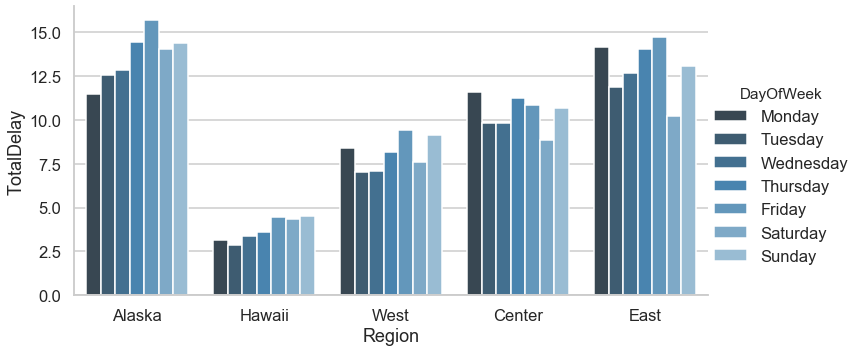

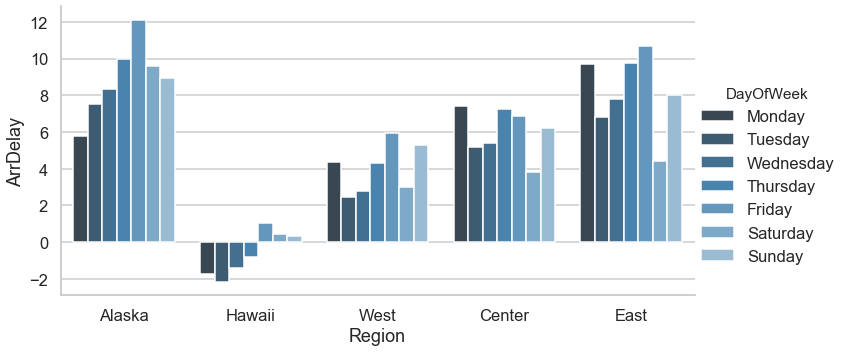

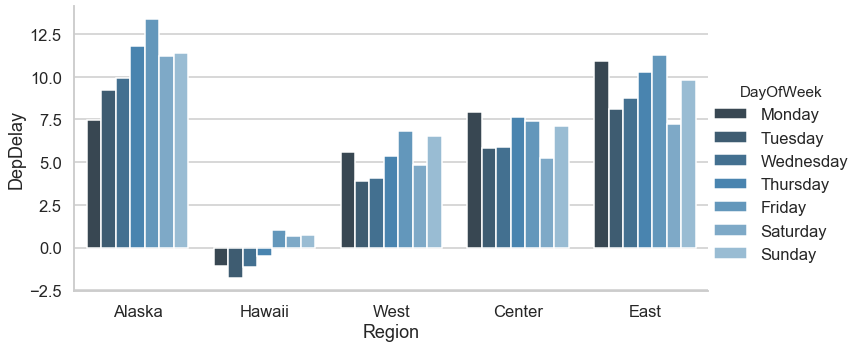

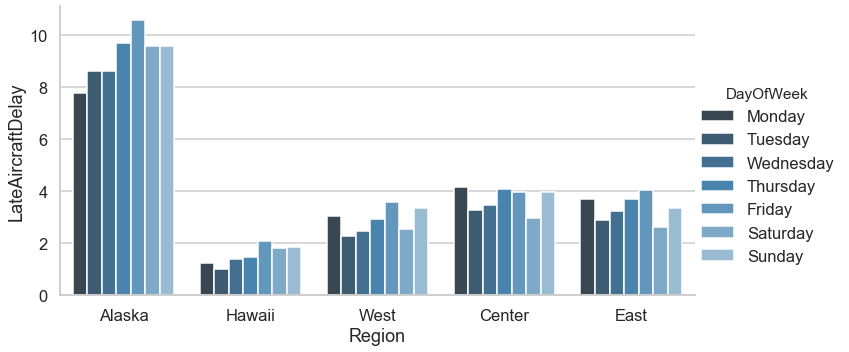

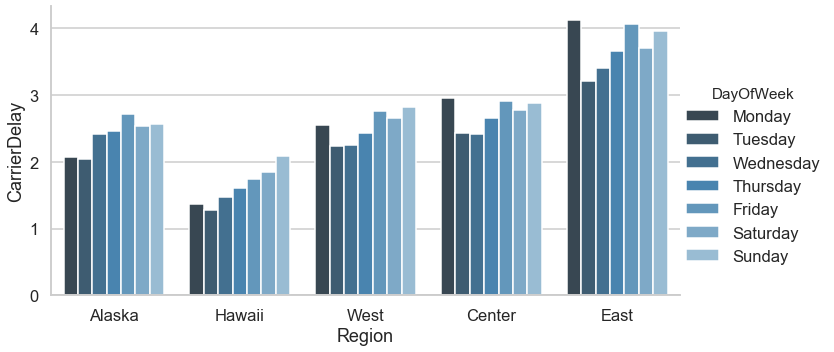

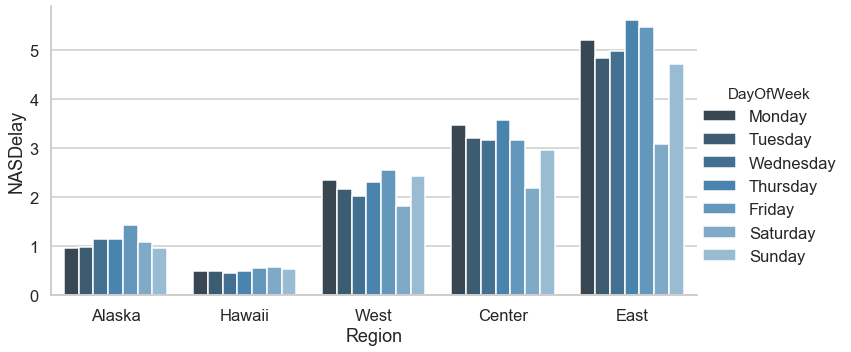

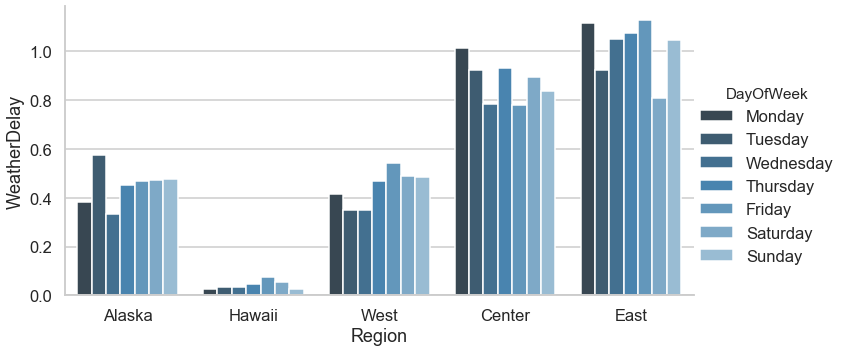

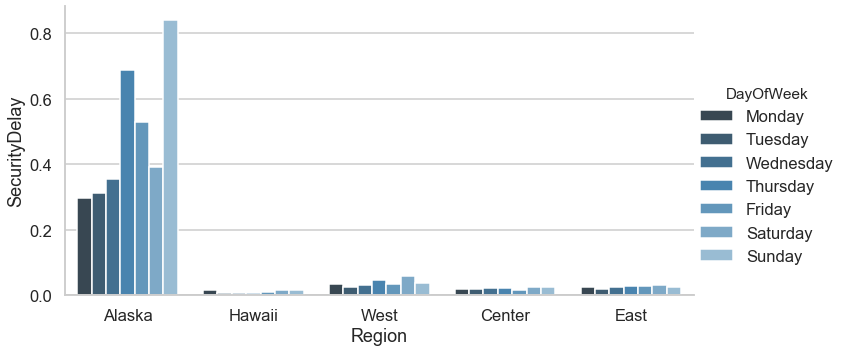

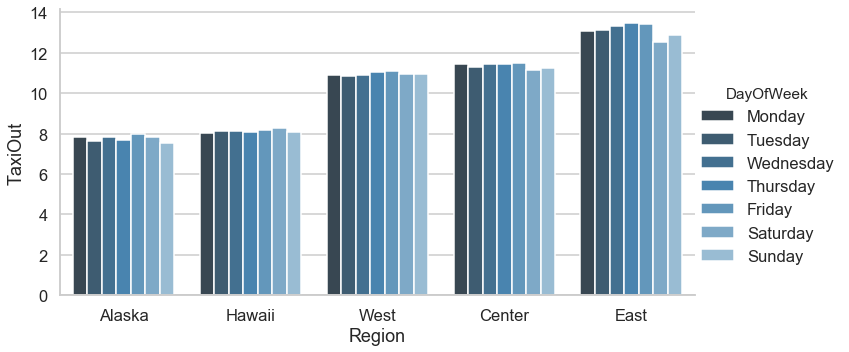

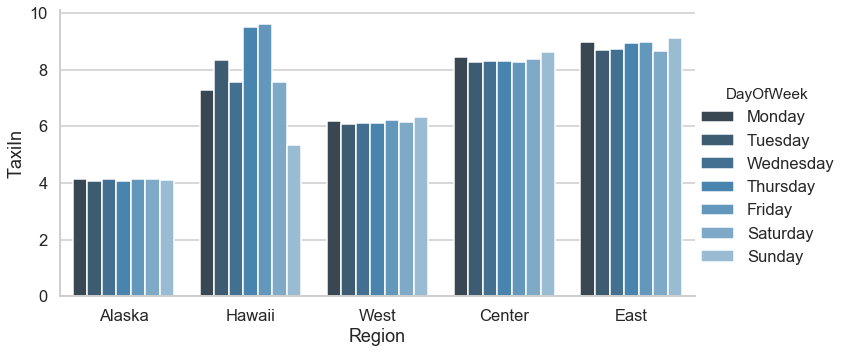

In [89]:
#I draws the factor plot with the results.
sns.set_palette("Blues_d", 7);

for i in range(len(numeric_vars_delay)):
    var = numeric_vars_delay[i]

    sns.catplot(x='Region', y=var, 
                   hue='DayOfWeek', data=df_origin_by_day, 
                   kind='bar', height=5, aspect=2, legend_out=True)
plt.show();

We can extract some conclusions from this pictures:

    * Alaska is the region with a greater delay mainly because of the Aircraft Delay. They have also a much bigger Security Delay comparatively with other regions, but this is very small and don't has a great impact in the total. Anyway the difference in the Security delay with other regions is remarkable.
    
    * Hawaii si the region with less delay, but if we focus in the Departure and Arrival Delays we can see a strange pattern. We have seen before that they usually have negative departures and arrival delays, but here we observe tha this are more negative on mondays and then go increasing along the week to remain positive on the weekend. It is strange but probably has a reason. Maybe some policy of the companys that operate there. I don't know.
    
    * In general some delays tend to increase along the week. Except some Monday effect that makes that these day usally have higher delays and the weekend where the delays fall again. We can see this for example in the Carrier Delay. In Hawaii and in Alaska there isn't an effect Monday. In this regions Mondays usually have the lowest or the second lowest delay of the week.

* Now we are going to do the same as before, but by month  instead of day of week.

In [90]:
#we get a new copy of tthe dataset df_origins filtered by year and grouped bu region and month
df_origin_by_month = df_origins.query('Date >= "2005-01-01"').groupby([ 'Region', 'Month']).mean()
df_origin_by_month = df_origin_by_month.reset_index()
#It changes the name of the days
df_origin_by_month['Month'] = df_origin_by_month['Month'].map({1: 'January', 
                                                               2: 'February',
                                                               3: 'March',
                                                               4: 'April',
                                                               5: 'May',
                                                               6: 'June',
                                                               7: 'July',
                                                               8: 'August',
                                                               9: 'September',
                                                               10: 'October',
                                                               11: 'November',
                                                               12: 'December'})
#set an order to the geographical regions
ordered_region = pd.api.types.CategoricalDtype(ordered = True, categories = ['Alaska', 'Hawaii', 'West', 'Center', 'East'])
df_origin_by_month['Region'] = df_origin_by_month['Region'].astype(ordered_region)

In [91]:
#We add the column Total Delay
df_origin_by_month['TotalDelay'] = df_origin_by_month['CarrierDelay'] +\
                                   df_origin_by_month['WeatherDelay'] +\
                                   df_origin_by_month['NASDelay'] +\
                                   df_origin_by_month['SecurityDelay'] +\
                                   df_origin_by_month['LateAircraftDelay']

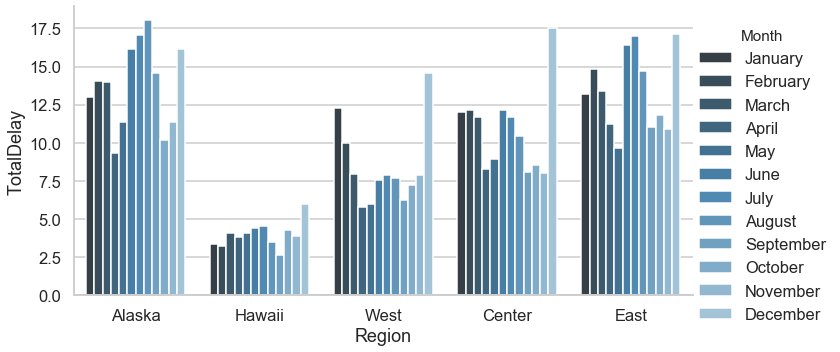

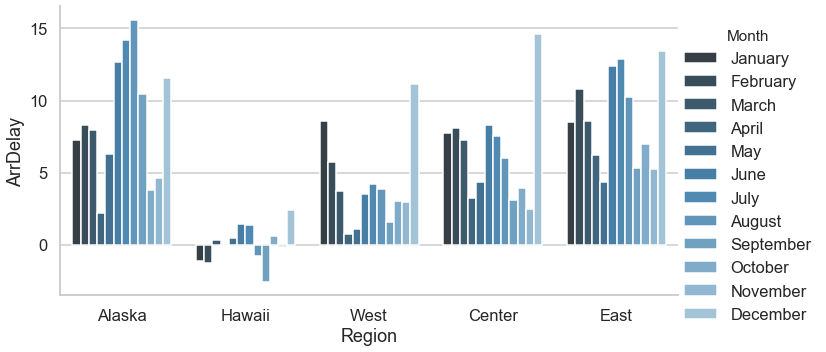

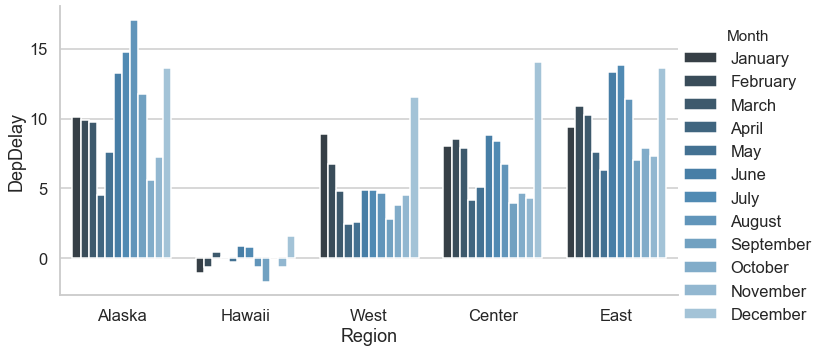

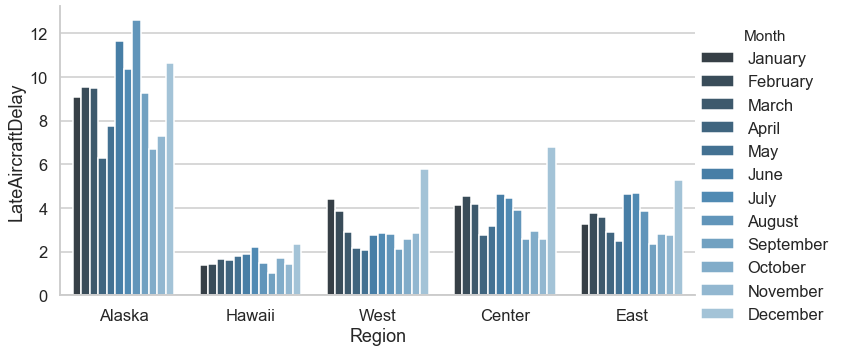

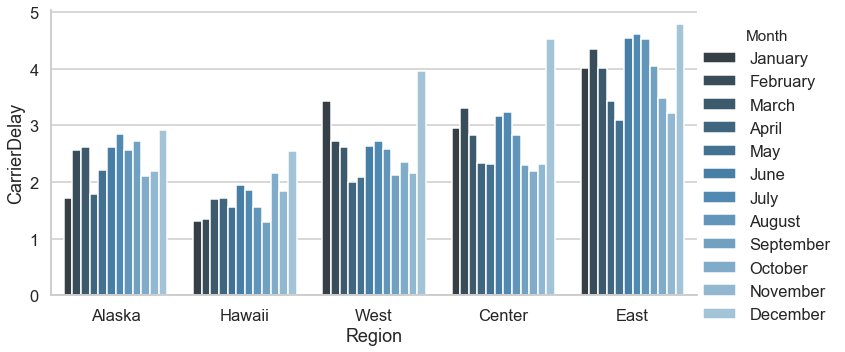

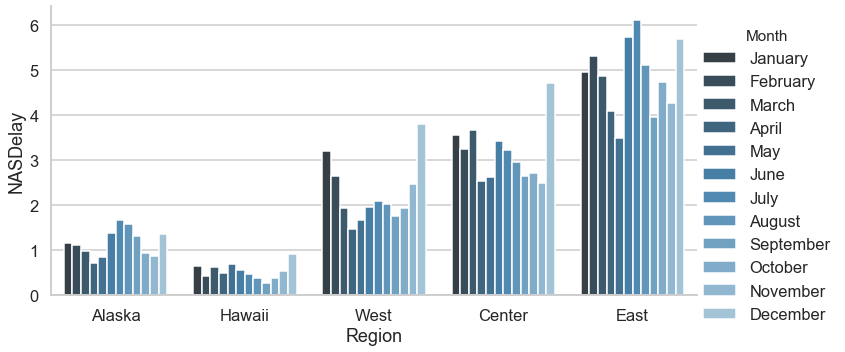

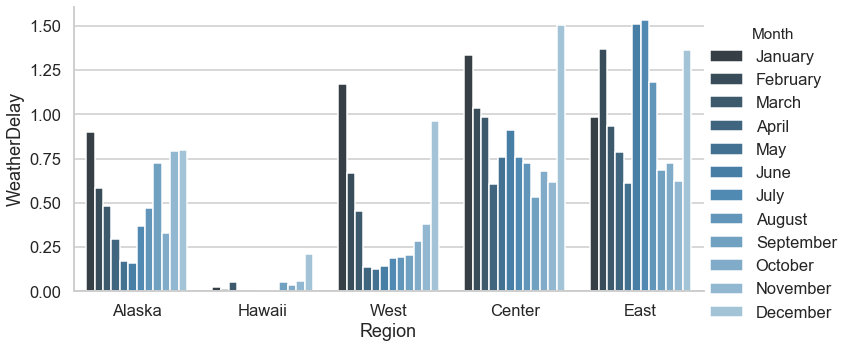

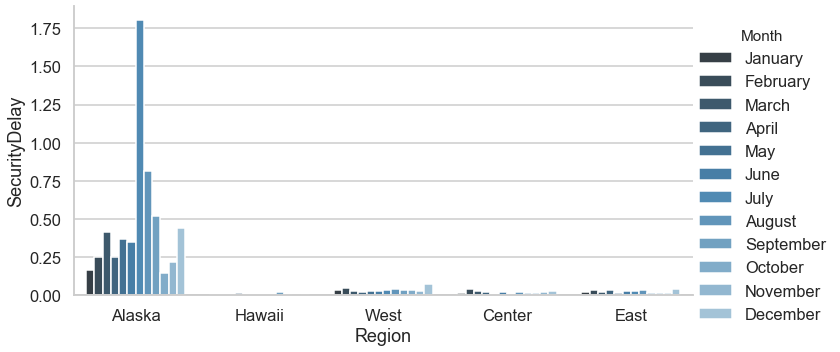

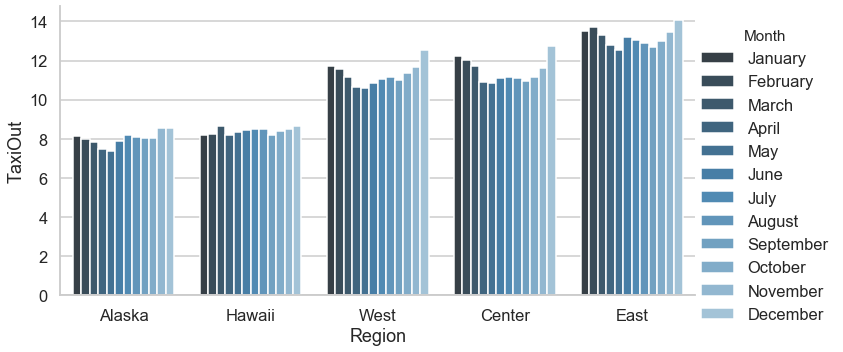

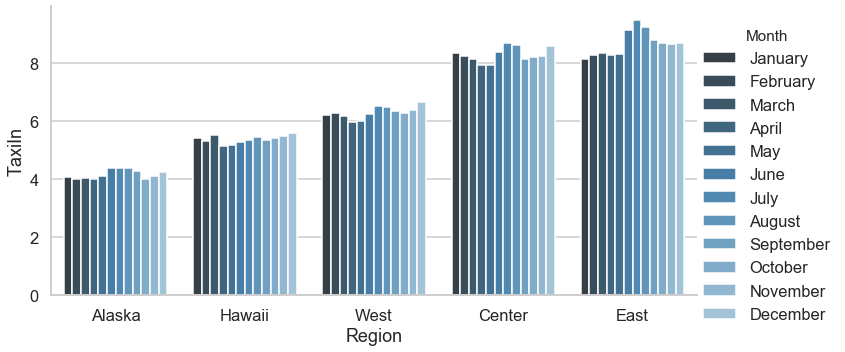

In [92]:
#I draws the factor plot with the results.
sns.set_palette("Blues_d", 12);

for i in range(len(numeric_vars_delay)):
    var = numeric_vars_delay[i]

    sns.catplot(x='Region', y=var, 
                   hue='Month', data=df_origin_by_month, 
                   kind='bar', height=5, aspect=2, legend_out=True)
plt.show();

* Afer seeing all the graphics so far, it seems pretty obvious that the geographical aspect is very important in terms of delay. We have been alway workin with airports of origin. I mean that this data corresponds to the geographical area to which the plane has took off. Exist the posibility of doing the analysis from the part of the airport of destiny to compare, but I don't go to do it by now. But there is a thing that I would like to know. Is there any difference in the delay if you travel to the North or you Travel to the south? And if you travel to the West or you travel to the East?

I have done this analysis using the datase `RouteByDay`. In this dataset I have information from the Origin and the Destiny airports. I can create two columns with the difference in `longitud` and `latitud` of these two points and I have converted them to int (to make bins). Then I have defined two dataframes grouping in one by the difference in longitude and in the other by by the difference in latitude.

After this I have simply draw two graphs with the difference in grades in the x-axis and the `Total Delay` in the y-axes.

In [93]:
#It calculates the Total Delay
df_routes['TotalDelay'] = df_routes['CarrierDelay'] +\
                          df_routes['WeatherDelay'] +\
                          df_routes['NASDelay'] +\
                          df_routes['SecurityDelay'] +\
                          df_routes['LateAircraftDelay']

In [94]:
#It divides the route column in two columns: Origin and Dest.
df_routes['Origin'], df_routes['Dest'] = df_routes['Route'].str.split('-', 1).str

In [95]:
#It merge the dataframe df_routes with columns about the data of the airport of origin
df_routes = df_routes.merge(df_airports_inf, how='left',left_on=['Origin'], right_on = ['iata'])
df_routes = df_routes.rename(columns = {'city': 'City_Origin', 'airport': 'Airport_Origin', 'state': 'State_Origin', 'country': 'Country_Origin', 'lat': 'Lat_Origin', 'long': 'Long_Origin'})
df_routes = df_routes.drop(columns = ['iata'])



In [96]:
#It merge the dataframe df_routes with columns about the data of the airport of destiny
df_routes = df_routes.merge(df_airports_inf, how='left',left_on=['Dest'], right_on = ['iata'])
df_routes = df_routes.rename(columns = {'city': 'City_Dest', 'airport': 'Airport_Dest', 'state': 'State_Dest', 'country': 'Country_Dest', 'lat': 'Lat_Dest', 'long': 'Long_Dest'})
df_routes = df_routes.drop(columns = ['iata'])


In [97]:
#It adds two columns with the difference in Latitud and Longitud. It converts the coordenates to int
df_routes['Difference_Long'] = (df_routes['Long_Dest']-df_routes['Long_Origin']).astype(int)
df_routes['Difference_Lat'] = (df_routes['Lat_Dest']-df_routes['Lat_Origin']).astype(int)

In [98]:
#We group all the dataframe by de difference in longitude
df_routes_long = df_routes.groupby(['Difference_Long']).mean()
df_routes_long = df_routes_long.reset_index()

#We group all the dataframe by de difference in latitiude
df_routes_lat = df_routes.groupby(['Difference_Lat']).mean()
df_routes_lat = df_routes_lat.reset_index()


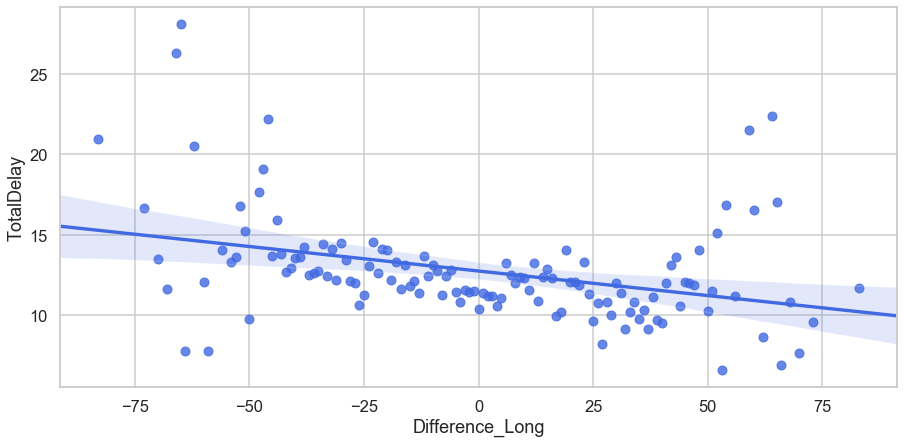

In [99]:
#It draws a regplot with the difference in long in the x-axis and the total delay in the y-axis 
plt.figure(figsize=(15,7))
sns.regplot(x="Difference_Long", y="TotalDelay", data=df_routes_long, color="royalblue");


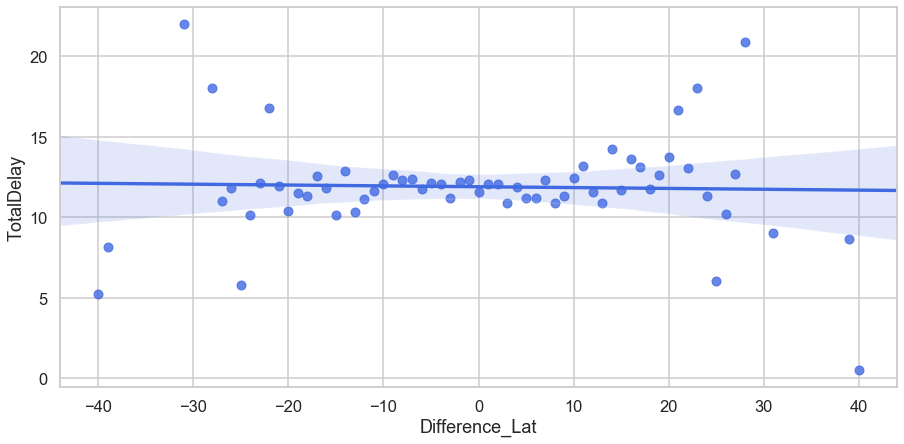

In [100]:
#It draws a regplot with the difference in latitude in the x-axis and the total delay in the y-axis 
plt.figure(figsize=(15,7))
sns.regplot(x="Difference_Lat", y="TotalDelay", data=df_routes_lat, color="royalblue");


* To end the analysis I am intersting in there are some cities that can be goog candidate to change this mean of transport for other one more ecological like high speed trains. I thought that it can be a good idea to search those routes or areas with a high level of traffic and with a mean speed of the flights slow enough so that a train could be competitive with planes.

In [163]:
#group the data of df_routes by route, preserving the information about airports
df_routes_group = df_routes.groupby(['Route', 'Origin', 'Dest', 'Airport_Origin', 'City_Origin', 'Airport_Dest',
                                        'Lat_Origin', 'Lat_Dest', 'Long_Origin', 'Long_Dest']).mean()

In [164]:
df_routes_group = df_routes_group.reset_index()

In [165]:
#Which routes have had a mean of flights greater than 15
df_routes_busy = df_routes_group.query('Count > 15')

In [166]:
#select distances greater than 300 miles
df_routes_busy = df_routes_busy.query('Distance > 300')

In [167]:
#calculates the speed in km/h
df_routes_busy['Speed'] = df_routes_busy['Distance'] /\
                          (df_routes_busy['ActualElapsedTime'] + df_routes_busy['TotalDelay']) *60 / 1.60934

In [168]:
#select thos routes with a mean speed smaller than 250 km/h
df_route_busy_slow = df_routes_busy.query('Speed < 250')

In [169]:
#discard those routes to Hawaii
df_route_busy_slow = df_route_busy_slow.query('Long_Dest > -130')

In [170]:
df_route_busy_slow = df_route_busy_slow.reset_index()
df_route_busy_slow['Count'] = df_route_busy_slow['Count'].round(1).astype(str)
df_route_busy_slow.Route.nunique()

96

In [174]:
#It draws a geographical plot of the result
fig = go.Figure()

#Add the lines of each route
flight_paths = []
for i in range(len(df_route_busy_slow)):
    fig.add_trace(
        go.Scattergeo(
            locationmode = 'USA-states',
            text = df_route_busy_slow['Airport_Origin'][i] + '-' + df_route_busy_slow['Airport_Dest'][i],
            lon = [df_route_busy_slow['Long_Origin'][i], df_route_busy_slow['Long_Dest'][i]],
            lat = [df_route_busy_slow['Lat_Origin'][i], df_route_busy_slow['Lat_Dest'][i]],
            mode = 'lines',
            line = dict(width = 1,color = 'red'),
            opacity = float(df_route_busy_slow['Count'][i]) / float(df_route_busy_slow['Count'].max()),
        )
    )
#configure layout
fig.update_layout(
    geo = dict(
        scope='usa',
        showland = True,
        landcolor = 'rgb(220, 220, 220)',
        countrycolor = 'rgb(204, 204, 204)',
        projection=go.layout.geo.Projection(type = 'albers usa'),
        showlakes=True, # lakes
        lakecolor='rgb(100, 100, 250)'),
    
)
fig.update_layout(
    showlegend = False,
    mapbox = dict(
        style="carto-darkmatter"),

)
#add points with the name of the airports.
fig.add_trace(go.Scattergeo(
    locationmode = 'USA-states',
    lon = df_route_busy_slow['Long_Origin'],
    lat = df_route_busy_slow['Lat_Origin'],
    hoverinfo = 'text',
    text = df_route_busy_slow['Airport_Origin'] + '/ ' + df_route_busy_slow['City_Origin'],
    mode = 'markers',
    marker = dict(
        size = 5,
        color = 'rgb(255, 0, 0)',
        line = dict(
            width = 3,
            color = 'rgba(68, 68, 68, 0)'
        )
    )))

fig.show()

In this map it is showed that the areas with routes more than 15 flights slower than 250 Km/h per day are manly two.
We can draw a line goes from Boston to New York, Atlanta and Miami. There are several routes between this points.
And we can draw another line between San Francisco to Los Angeles and Phoenix.
We can see also that there is like a corridor beteen the New York area, Chicago, Denver and Los Angeles. This would be a good way to join the east with the west.
We leave isolated Dallas in the south, that countain also many of this busy routes. I am not sure of what could be the best option to join this city with the rest of the network, maybe a line to Atlant and other to Denver could be good solutions.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

We can extract the next main conlcusions from this analyis:

* There are less departures on weekends in the continents, while in Alaska is relatively constant along the week. In Hawaii we can see that the days with more departures are Fridays and Saturdays.

* Mondays are usually a bad day in terms of delay in the continent. Is not so in Alaska and Hawaii. Then the total delay decrease on Tuesday, but in general tends to go increasing the next of the week. 

* This tendency to have an increasing slope along the week is specially obvious in Alaska, Hawayii and the East Coast and in the Carrier and NAS causes. 

* The delay decreases again on Saturdays in all regions and grows on Sundays.

* Regarding to the month of the year we can see that the region that have a biggest variation of traffic between months is Alaska. The percentage of traffic is really gigger in the summer months. In the other regions this fifference between months is not so big, although Hawaii has also a considerably increment of traffic in July and August.

* December is a bad day to travel in all the regions. Janueary, February and March are also bad except in Hawaii.

* Finally June, July and August are also bad months, expecially in the East Coast and in Alaska. In this region must be very important that they have a great amount of traffic these months. In the case of the East Region all the causes of delay suffer an increment these months but we can remark the increment in the Wheather delays because of the Hurricans Season.

* In the analysis of the delay in relation with the direction of the flight we ha seen that we have a litle more delay if we travel to West than if we travel to the East. In vertical direction we don't appreciate any difeerence.

* Analyzing the routes with more than 15 flights per day and with a mean speed slower than 250 km/h we have found some possible options to develop another mean of transport more ecological like the high speed trains: 

      * One of this options could be a line from San Francisco to Los Angeles and Phoenix. 
      * Other option could be from Boston to New York, Atlanta and Miami.
      * And to link the both coast we could make a corridor beteen the New York area, Chicago, Denver and Los Angeles.


### Were there any interesting or surprising interactions between features?

* The most surprising interaction is the effect that the direction of the flight has over the delay. It seems that the total delay is bigger if we travel to the West than if we travel to the East. This difference does not exist North and South direction. We could think that the movement of rotation of the Earth has some influence on that. But if it is so, to move to the West, against the rotation of the Earth should suppose a decrement in the time to get the destiny. It could been happening that the companies take this into account and they priorize one direction over another to compensate the influence of the earth movement? It is really strange, but I don't know. It could be also because of simply different condition of the winds.

* It is also strange tha the Departure and Arrival delays in Hawaii start the week with negative values and end with positive values. It seems like they want to have a mean value of 0 algong the week. It is really strange also, but I don't know the cause.

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!